In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook
from tqdm import tnrange

# Using default dataset (+ Boilerplate code)

In [2]:
number_of_imgs_to_load_foreach_class = 5
fixed_patch_size = 60

In [3]:
def extract_images(folder_path, split_separator = '_'):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split(split_separator)[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

In [5]:
images = [cv2.imread(img) for img in images]
len(images)

27

In [6]:
len(images_classes), len(set(images_classes))

(27, 6)

In [7]:
classes = set(images_classes)
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [8]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

In [9]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


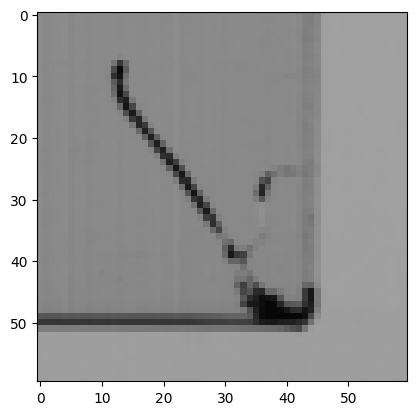

In [10]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', fixed_patch_size)
print(ex.shape)
plt.imshow(ex)

In [11]:
def preprocess_images(dict, index, size):
    for key in dict.keys():
        dict[key] = [img[:index] + '/' + img[index + 1:] for img in dict[key]]
        dict[key] = [aug for img in dict[key] for aug in augment_image(cv2.imread(img))]
        dict[key] = [resize_image(img, key, size) for img in dict[key]]
    
    return dict

In [12]:
def extend_target_classes(images_classes, n):
    target_classes = []
    for cls in images_classes:
        target_classes.extend([cls] * n)
    
    return target_classes

In [13]:
images_dict = preprocess_images(images_dict, 11, fixed_patch_size)

In [14]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': list(K)
    })

In [15]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['break' 'dirt' 'scratch' 'mark' 'bubble' 'point']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161,  ..., 139, 136, 138]],
  
            [[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161,  ..., 139, 136, 138]],
  
            [[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161, 

In [16]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

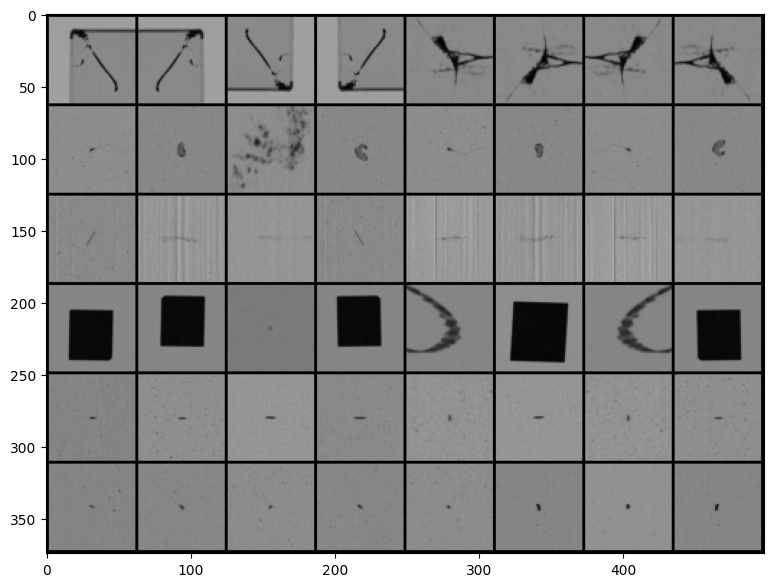

In [17]:
display_sample(sample_example['images'])

In [18]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [19]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample, accuracy_dict):
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        sample_labels = sample['classes']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        dists = euclidean_dist(z_query, z_proto)

        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        accuracy_tensor = []
        for row_target, row_predicted in zip(target_inds.squeeze(), y_hat.squeeze()):
            accuracy = (row_target == row_predicted).float().mean()
            accuracy_tensor.append([accuracy])
        accuracy_tensor = torch.tensor(accuracy_tensor)

        for accuracy, cls in zip(accuracy_tensor, sample_labels):
            if cls not in accuracy_dict:
                accuracy_dict[cls] = []
            accuracy_dict[cls].append(accuracy.item())

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }, accuracy_dict

In [20]:
class Flatten(nn.Module):
    def __init__(self):
      super(Flatten, self).__init__()

    def forward(self, x):
      return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
    
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
      
    return ProtoNet(encoder)

In [21]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))
    
    return train_x, train_y, test_x, test_y

# Train

In [22]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 

    accuracy_dict = {}
    final_accuracy = 0

    while epoch < epochs:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            final_accuracy = epoch_acc
            epoch += 1
            scheduler.step()

    return accuracy_dict, final_accuracy

In [23]:
# def print_dictionary(dictionary):
#     for key, values in dictionary.items():
#         average = round(sum(values) / len(values), 3)
#         print(f"{key}: Average recall: {average}")

In [24]:
# %%time

# model = load_protonet_conv(
#     x_dim=(3,60,60),
#     hid_dim=64,
#     z_dim=64,
# )

# optimizer = optim.Adam(model.parameters(), lr = 0.001)

# n_way = 3
# n_support = 2
# n_query = 1

# epochs = 10
# episodes = 50

# accuracy_dict, _ = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes)
# print('----------------------------------------------')
# print_dictionary(accuracy_dict)

# Test

In [25]:
def test(model, test_x, test_y, n_way, n_support, n_query, episodes):
    running_loss = 0.0
    running_acc = 0.0

    accuracy_dict = {}

    for episode in tnrange(episodes):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / episodes
    avg_acc = running_acc / episodes
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return accuracy_dict, avg_acc

In [26]:
# n_way = 6
# n_support = 2
# n_query = 2

# episodes = 50

# accuracy_dict, _ = test(model, test_x, test_y, n_way, n_support, n_query, episodes)
# print('----------------------------------------------')
# print_dictionary(accuracy_dict)

# test on specific sample

In [27]:
# accuracy_dict = {}

In [28]:
# my_sample = extract_sample(3, 1, 1, test_x, test_y)
# display_sample(my_sample['images'])
# model = load_protonet_conv(
#     x_dim=(3,60,60),
#     hid_dim=64,
#     z_dim=64,
# )
# my_loss, my_output, accuracy_dict = model.set_forward_loss(my_sample, accuracy_dict)
# print_dictionary(accuracy_dict)
# my_output

In [29]:
def train_test_pipeline(images_dict, split_percentage = 3/4, 
                        train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, train_episodes = 50, 
                        test_n_way = 3, test_n_support = 1, test_n_query = 1, test_episodes = 50):
    
    train_x, train_y, test_x, test_y = split_train_test(images_dict, split_percentage)

    model = load_protonet_conv(
        x_dim=(3,fixed_patch_size,fixed_patch_size),
        hid_dim=64,
        z_dim=64,
    )

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_accuracy_dict, train_accuracy = train(model, optimizer, train_x, train_y, train_n_way, train_n_support, train_n_query, train_epochs, train_episodes)
    test_accuracy_dict, test_accuracy = test(model, test_x, test_y, test_n_way, test_n_support, test_n_query, test_episodes)

    return train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy

In [30]:
def plot_accuracies_dict(accuracies_dict, title):
    for dictionary in accuracies_dict:
        dictionary = dict(sorted(dictionary.items()))
        keys = list(dictionary.keys())
        values = list(dictionary.values())
        x = range(len(keys))
        values = [sum(sublist) / len(sublist) for sublist in values]

        plt.figure(figsize=(6, 4))
        plt.bar(x, values)
        plt.xticks(x, keys)
        plt.xticks(rotation=90)
        plt.ylim(0, 1)
        plt.xlabel('labels')
        plt.ylabel('recalls')
        plt.title(title)
        plt.show()

In [31]:
def plot_accuracies(increased_episodes, train_accuracies, test_accuracies):
    plt.plot(increased_episodes, train_accuracies, label='train_accuracies')
    plt.plot(increased_episodes, test_accuracies, label='test_accuracies')
    plt.ylim(0, 1)
    plt.xlabel('# of episodes')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('evolution of accuracy with # of episodes')
    plt.show()

In [32]:
def exec_multiple_episodes(episodes_list = [50, 100, 250, 500],
                            train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, 
                            test_n_way = 3, test_n_support = 1, test_n_query = 1):
    train_accuracies_dict, test_accuracies_dict = [], []
    train_accuracies, test_accuracies = [], []

    for episodes in episodes_list:
        train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_n_way = train_n_way, train_n_support = train_n_support, train_n_query = train_n_query, train_epochs = train_epochs, train_episodes = episodes, test_n_way = test_n_way, test_n_support = test_n_support, test_n_query = test_n_query, test_episodes = episodes)
        train_accuracies_dict.append(train_accuracy_dict)
        test_accuracies_dict.append(test_accuracy_dict)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies

# Training and testing on different number of episodes

In [33]:
images, images_classes, images_dict = extract_images('../data/img/')
images_dict = preprocess_images(images_dict, 11, fixed_patch_size)

In [34]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'point' 'bubble']
Epoch 1 -- Loss: 4.0096 Acc: 0.0133
K: ['dirt' 'break' 'point']
Epoch 2 -- Loss: 4.4464 Acc: 0.0267
K: ['scratch' 'mark' 'break']
Epoch 3 -- Loss: 4.8226 Acc: 0.0400
K: ['scratch' 'point' 'dirt']
Epoch 4 -- Loss: 4.8429 Acc: 0.0533
K: ['scratch' 'point' 'dirt']
Epoch 5 -- Loss: 5.1833 Acc: 0.0667
K: ['break' 'scratch' 'mark']
Epoch 6 -- Loss: 5.1833 Acc: 0.0867
K: ['break' 'point' 'dirt']
Epoch 7 -- Loss: 5.5759 Acc: 0.0933
K: ['bubble' 'dirt' 'point']
Epoch 8 -- Loss: 6.7718 Acc: 0.1067
K: ['mark' 'point' 'scratch']
Epoch 9 -- Loss: 7.4748 Acc: 0.1200
K: ['break' 'scratch' 'dirt']
Epoch 10 -- Loss: 7.7196 Acc: 0.1333
K: ['mark' 'scratch' 'bubble']
Epoch 11 -- Loss: 7.7196 Acc: 0.1533
K: ['break' 'dirt' 'bubble']
Epoch 12 -- Loss: 8.9986 Acc: 0.1600
K: ['scratch' 'dirt' 'break']
Epoch 13 -- Loss: 8.9986 Acc: 0.1800
K: ['scratch' 'mark' 'point']
Epoch 14 -- Loss: 8.9986 Acc: 0.2000
K: ['bubble' 'dirt' 'break']
Epoch 15 -- Loss: 9.5003 Acc: 0.2067
K: ['mark' 

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'scratch' 'break']
K: ['bubble' 'point' 'break']
K: ['point' 'break' 'bubble']
K: ['bubble' 'dirt' 'break']
K: ['break' 'bubble' 'mark']
K: ['mark' 'break' 'dirt']
K: ['break' 'bubble' 'point']
K: ['point' 'mark' 'break']
K: ['scratch' 'dirt' 'mark']
K: ['bubble' 'dirt' 'scratch']
K: ['scratch' 'dirt' 'point']
K: ['scratch' 'bubble' 'point']
K: ['bubble' 'dirt' 'scratch']
K: ['scratch' 'bubble' 'mark']
K: ['scratch' 'dirt' 'break']
K: ['scratch' 'mark' 'point']
K: ['bubble' 'break' 'mark']
K: ['mark' 'dirt' 'break']
K: ['bubble' 'dirt' 'scratch']
K: ['mark' 'point' 'break']
K: ['dirt' 'mark' 'bubble']
K: ['mark' 'break' 'dirt']
K: ['point' 'dirt' 'bubble']
K: ['bubble' 'point' 'dirt']
K: ['break' 'mark' 'scratch']
K: ['bubble' 'mark' 'scratch']
K: ['break' 'scratch' 'dirt']
K: ['point' 'dirt' 'scratch']
K: ['scratch' 'mark' 'bubble']
K: ['bubble' 'point' 'scratch']
K: ['bubble' 'break' 'dirt']
K: ['scratch' 'break' 'dirt']
K: ['break' 'mark' 'scratch']
K: ['dirt' 'mark' 'bre

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['scratch' 'bubble' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0100
K: ['scratch' 'mark' 'point']
Epoch 2 -- Loss: 0.0000 Acc: 0.0200
K: ['dirt' 'point' 'bubble']
Epoch 3 -- Loss: 0.0000 Acc: 0.0300
K: ['break' 'mark' 'dirt']
Epoch 4 -- Loss: 1.1565 Acc: 0.0367
K: ['dirt' 'break' 'bubble']
Epoch 5 -- Loss: 1.4680 Acc: 0.0433
K: ['dirt' 'point' 'bubble']
Epoch 6 -- Loss: 1.7670 Acc: 0.0467
K: ['scratch' 'bubble' 'break']
Epoch 7 -- Loss: 1.7670 Acc: 0.0567
K: ['point' 'break' 'bubble']
Epoch 8 -- Loss: 1.9439 Acc: 0.0633
K: ['scratch' 'dirt' 'mark']
Epoch 9 -- Loss: 2.5465 Acc: 0.0700
K: ['bubble' 'scratch' 'mark']
Epoch 10 -- Loss: 2.5465 Acc: 0.0800
K: ['point' 'dirt' 'bubble']
Epoch 11 -- Loss: 2.8607 Acc: 0.0867
K: ['point' 'break' 'dirt']
Epoch 12 -- Loss: 2.8751 Acc: 0.0933
K: ['mark' 'scratch' 'point']
Epoch 13 -- Loss: 2.8751 Acc: 0.1033
K: ['point' 'break' 'scratch']
Epoch 14 -- Loss: 2.8751 Acc: 0.1133
K: ['point' 'mark' 'break']
Epoch 15 -- Loss: 2.8751 Acc: 0.1233
K: ['scrat

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'dirt' 'break']
K: ['mark' 'point' 'bubble']
K: ['break' 'point' 'scratch']
K: ['point' 'dirt' 'mark']
K: ['point' 'mark' 'scratch']
K: ['mark' 'bubble' 'scratch']
K: ['point' 'break' 'mark']
K: ['point' 'bubble' 'scratch']
K: ['mark' 'dirt' 'bubble']
K: ['scratch' 'break' 'bubble']
K: ['scratch' 'mark' 'dirt']
K: ['bubble' 'scratch' 'dirt']
K: ['point' 'break' 'dirt']
K: ['scratch' 'break' 'dirt']
K: ['mark' 'bubble' 'scratch']
K: ['bubble' 'mark' 'point']
K: ['dirt' 'bubble' 'mark']
K: ['scratch' 'point' 'dirt']
K: ['mark' 'bubble' 'scratch']
K: ['dirt' 'break' 'mark']
K: ['break' 'point' 'scratch']
K: ['break' 'dirt' 'bubble']
K: ['mark' 'scratch' 'dirt']
K: ['dirt' 'mark' 'break']
K: ['scratch' 'bubble' 'dirt']
K: ['mark' 'dirt' 'point']
K: ['scratch' 'break' 'dirt']
K: ['mark' 'point' 'bubble']
K: ['scratch' 'break' 'mark']
K: ['scratch' 'bubble' 'dirt']
K: ['mark' 'break' 'scratch']
K: ['point' 'mark' 'dirt']
K: ['dirt' 'point' 'bubble']
K: ['point' 'dirt' 'bubble']


Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'point' 'mark']
Epoch 1 -- Loss: 0.7027 Acc: 0.0013
K: ['point' 'break' 'scratch']
Epoch 2 -- Loss: 0.7154 Acc: 0.0040
K: ['break' 'bubble' 'point']
Epoch 3 -- Loss: 0.7498 Acc: 0.0067
K: ['mark' 'break' 'bubble']
Epoch 4 -- Loss: 0.7498 Acc: 0.0107
K: ['bubble' 'point' 'dirt']
Epoch 5 -- Loss: 0.9775 Acc: 0.0120
K: ['mark' 'dirt' 'break']
Epoch 6 -- Loss: 0.9775 Acc: 0.0160
K: ['point' 'scratch' 'mark']
Epoch 7 -- Loss: 0.9775 Acc: 0.0200
K: ['scratch' 'bubble' 'mark']
Epoch 8 -- Loss: 0.9775 Acc: 0.0240
K: ['point' 'dirt' 'break']
Epoch 9 -- Loss: 0.9775 Acc: 0.0280
K: ['point' 'scratch' 'mark']
Epoch 10 -- Loss: 0.9775 Acc: 0.0320
K: ['bubble' 'mark' 'break']
Epoch 11 -- Loss: 1.0800 Acc: 0.0347
K: ['mark' 'scratch' 'dirt']
Epoch 12 -- Loss: 1.0816 Acc: 0.0373
K: ['mark' 'break' 'bubble']
Epoch 13 -- Loss: 1.0816 Acc: 0.0413
K: ['point' 'break' 'dirt']
Epoch 14 -- Loss: 1.0816 Acc: 0.0453
K: ['bubble' 'break' 'point']
Epoch 15 -- Loss: 1.0816 Acc: 0.0493
K: ['mark' 'break

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['point' 'dirt' 'scratch']
K: ['dirt' 'break' 'scratch']
K: ['break' 'point' 'dirt']
K: ['scratch' 'bubble' 'break']
K: ['mark' 'scratch' 'dirt']
K: ['mark' 'bubble' 'break']
K: ['mark' 'dirt' 'scratch']
K: ['mark' 'scratch' 'bubble']
K: ['dirt' 'mark' 'scratch']
K: ['scratch' 'break' 'mark']
K: ['break' 'mark' 'bubble']
K: ['bubble' 'break' 'dirt']
K: ['mark' 'scratch' 'break']
K: ['dirt' 'break' 'mark']
K: ['point' 'scratch' 'mark']
K: ['point' 'dirt' 'break']
K: ['point' 'bubble' 'break']
K: ['bubble' 'point' 'scratch']
K: ['scratch' 'dirt' 'break']
K: ['bubble' 'point' 'scratch']
K: ['break' 'point' 'mark']
K: ['bubble' 'dirt' 'mark']
K: ['mark' 'scratch' 'bubble']
K: ['dirt' 'break' 'point']
K: ['break' 'scratch' 'dirt']
K: ['mark' 'bubble' 'dirt']
K: ['bubble' 'point' 'scratch']
K: ['dirt' 'mark' 'break']
K: ['point' 'dirt' 'break']
K: ['bubble' 'point' 'scratch']
K: ['point' 'break' 'bubble']
K: ['break' 'mark' 'point']
K: ['break' 'scratch' 'bubble']
K: ['point' 'break' 'bub

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'break' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0020
K: ['mark' 'break' 'point']
Epoch 2 -- Loss: 0.0000 Acc: 0.0040
K: ['break' 'point' 'scratch']
Epoch 3 -- Loss: 0.0000 Acc: 0.0060
K: ['bubble' 'scratch' 'break']
Epoch 4 -- Loss: 0.0000 Acc: 0.0080
K: ['break' 'dirt' 'bubble']
Epoch 5 -- Loss: 0.0000 Acc: 0.0100
K: ['bubble' 'point' 'break']
Epoch 6 -- Loss: 0.0031 Acc: 0.0113
K: ['point' 'scratch' 'dirt']
Epoch 7 -- Loss: 0.0798 Acc: 0.0127
K: ['point' 'scratch' 'bubble']
Epoch 8 -- Loss: 0.1477 Acc: 0.0140
K: ['scratch' 'dirt' 'bubble']
Epoch 9 -- Loss: 0.1477 Acc: 0.0160
K: ['dirt' 'break' 'mark']
Epoch 10 -- Loss: 0.1477 Acc: 0.0180
K: ['mark' 'bubble' 'break']
Epoch 11 -- Loss: 0.2202 Acc: 0.0193
K: ['scratch' 'break' 'point']
Epoch 12 -- Loss: 0.2202 Acc: 0.0213
K: ['mark' 'dirt' 'scratch']
Epoch 13 -- Loss: 0.2202 Acc: 0.0233
K: ['scratch' 'point' 'bubble']
Epoch 14 -- Loss: 0.3001 Acc: 0.0247
K: ['mark' 'break' 'point']
Epoch 15 -- Loss: 0.3001 Acc: 0.0267
K: 

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'point' 'break']
K: ['bubble' 'point' 'mark']
K: ['point' 'scratch' 'bubble']
K: ['break' 'mark' 'point']
K: ['dirt' 'break' 'bubble']
K: ['bubble' 'scratch' 'point']
K: ['break' 'point' 'scratch']
K: ['scratch' 'point' 'break']
K: ['scratch' 'mark' 'bubble']
K: ['mark' 'bubble' 'break']
K: ['scratch' 'point' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['point' 'mark' 'dirt']
K: ['mark' 'dirt' 'point']
K: ['dirt' 'break' 'bubble']
K: ['mark' 'break' 'scratch']
K: ['dirt' 'bubble' 'break']
K: ['mark' 'bubble' 'break']
K: ['scratch' 'dirt' 'bubble']
K: ['scratch' 'point' 'mark']
K: ['point' 'dirt' 'scratch']
K: ['break' 'dirt' 'scratch']
K: ['break' 'scratch' 'dirt']
K: ['point' 'scratch' 'dirt']
K: ['bubble' 'mark' 'dirt']
K: ['break' 'scratch' 'point']
K: ['break' 'bubble' 'scratch']
K: ['scratch' 'point' 'break']
K: ['mark' 'dirt' 'break']
K: ['break' 'bubble' 'point']
K: ['scratch' 'bubble' 'mark']
K: ['mark' 'bubble' 'point']
K: ['point' 'scratch' 'bubble']
K: ['mark' 'b

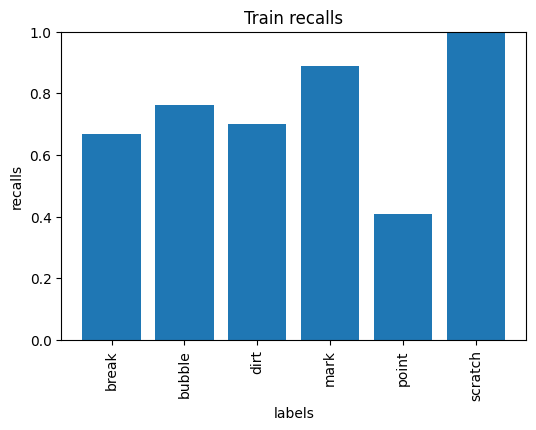

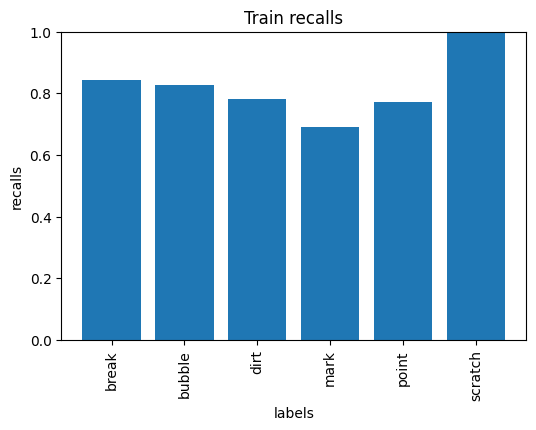

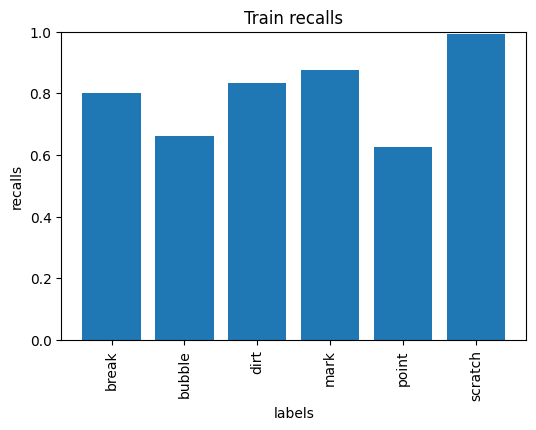

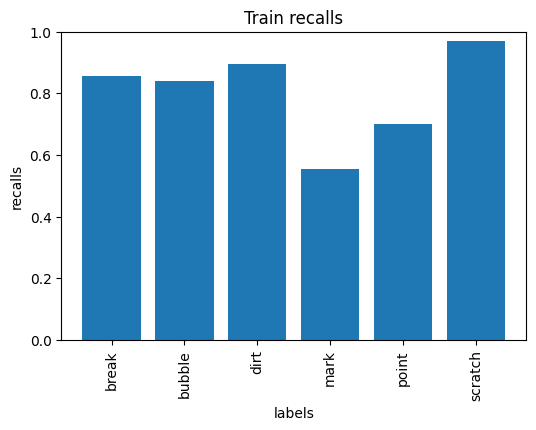

In [35]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

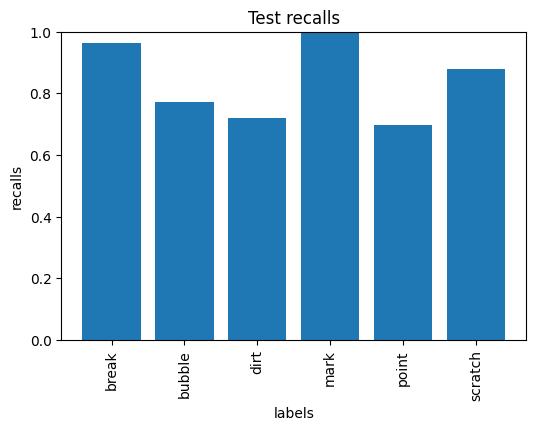

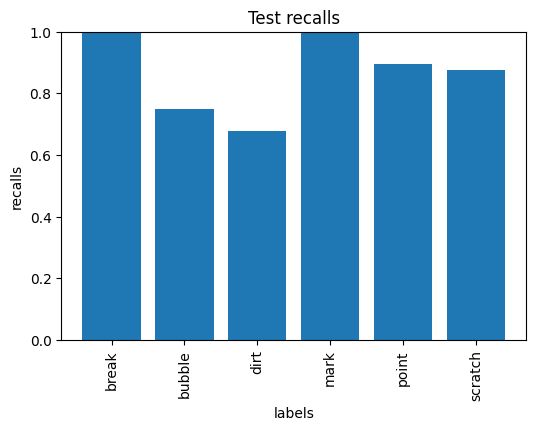

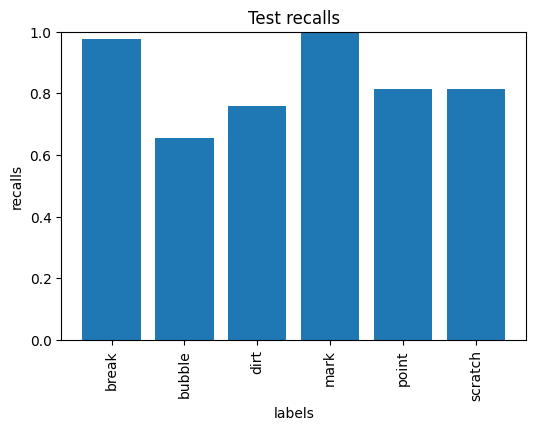

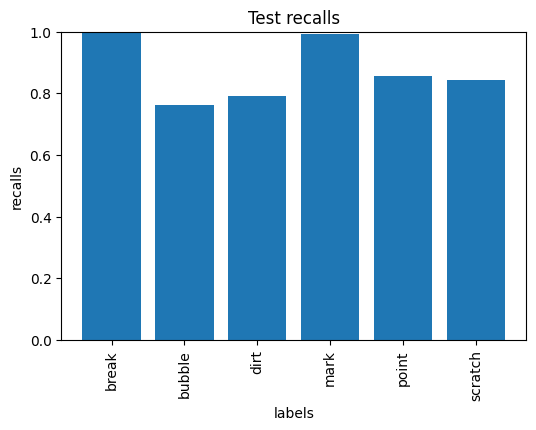

In [36]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

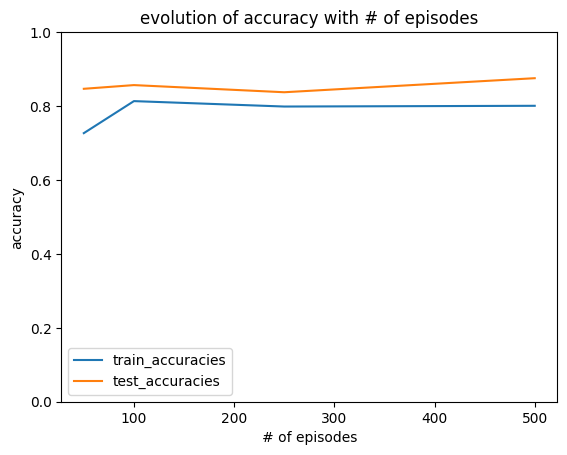

In [37]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using default dataset + background (opt_bckg)

In [38]:
images, images_classes, images_dict = extract_images('../data/views_opt_bckg/img/')
images_dict = preprocess_images(images_dict, 26, fixed_patch_size)

In [39]:
classes = set(images_classes)
classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [40]:
# train_test_pipeline(images_dict);

# Training and testing on different number of episodes

In [41]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt' 'background' 'break']
Epoch 1 -- Loss: 2.0681 Acc: 0.0133
K: ['point' 'bubble' 'background']
Epoch 2 -- Loss: 3.1386 Acc: 0.0200
K: ['break' 'background' 'scratch']
Epoch 3 -- Loss: 3.6015 Acc: 0.0333
K: ['point' 'bubble' 'scratch']
Epoch 4 -- Loss: 3.6015 Acc: 0.0533
K: ['dirt' 'background' 'point']
Epoch 5 -- Loss: 3.6015 Acc: 0.0733
K: ['point' 'dirt' 'scratch']
Epoch 6 -- Loss: 3.6088 Acc: 0.0867
K: ['bubble' 'dirt' 'point']
Epoch 7 -- Loss: 4.7550 Acc: 0.0933
K: ['point' 'dirt' 'background']
Epoch 8 -- Loss: 4.7550 Acc: 0.1133
K: ['dirt' 'break' 'background']
Epoch 9 -- Loss: 5.0047 Acc: 0.1267
K: ['point' 'dirt' 'bubble']
Epoch 10 -- Loss: 5.7123 Acc: 0.1333
K: ['scratch' 'point' 'background']
Epoch 11 -- Loss: 5.7123 Acc: 0.1533
K: ['break' 'scratch' 'mark']
Epoch 12 -- Loss: 5.7123 Acc: 0.1733
K: ['scratch' 'break' 'background']
Epoch 13 -- Loss: 6.3630 Acc: 0.1800
K: ['dirt' 'break' 'bubble']
Epoch 14 -- Loss: 6.4690 Acc: 0.1933
K: ['mark' 'break' 'bubble']
Epoch 15

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['scratch' 'bubble' 'background']
K: ['point' 'bubble' 'break']
K: ['point' 'dirt' 'scratch']
K: ['dirt' 'break' 'background']
K: ['background' 'break' 'bubble']
K: ['scratch' 'background' 'dirt']
K: ['bubble' 'point' 'dirt']
K: ['point' 'background' 'break']
K: ['mark' 'bubble' 'point']
K: ['bubble' 'point' 'break']
K: ['dirt' 'break' 'scratch']
K: ['background' 'scratch' 'dirt']
K: ['scratch' 'mark' 'point']
K: ['mark' 'point' 'bubble']
K: ['point' 'scratch' 'mark']
K: ['dirt' 'scratch' 'mark']
K: ['scratch' 'mark' 'break']
K: ['point' 'background' 'bubble']
K: ['point' 'mark' 'scratch']
K: ['bubble' 'mark' 'scratch']
K: ['mark' 'scratch' 'dirt']
K: ['dirt' 'break' 'mark']
K: ['break' 'background' 'bubble']
K: ['mark' 'scratch' 'bubble']
K: ['point' 'scratch' 'bubble']
K: ['scratch' 'dirt' 'mark']
K: ['scratch' 'background' 'mark']
K: ['point' 'mark' 'background']
K: ['break' 'scratch' 'background']
K: ['scratch' 'point' 'background']
K: ['bubble' 'break' 'mark']
K: ['scratch' 'po

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['mark' 'bubble' 'background']
Epoch 1 -- Loss: 1.9013 Acc: 0.0067
K: ['scratch' 'bubble' 'break']
Epoch 2 -- Loss: 1.9013 Acc: 0.0167
K: ['scratch' 'mark' 'break']
Epoch 3 -- Loss: 1.9050 Acc: 0.0233
K: ['bubble' 'break' 'mark']
Epoch 4 -- Loss: 1.9050 Acc: 0.0333
K: ['dirt' 'break' 'point']
Epoch 5 -- Loss: 1.9390 Acc: 0.0367
K: ['break' 'background' 'point']
Epoch 6 -- Loss: 1.9390 Acc: 0.0467
K: ['bubble' 'break' 'dirt']
Epoch 7 -- Loss: 1.9390 Acc: 0.0567
K: ['mark' 'background' 'break']
Epoch 8 -- Loss: 3.3033 Acc: 0.0633
K: ['dirt' 'point' 'background']
Epoch 9 -- Loss: 3.3033 Acc: 0.0733
K: ['mark' 'scratch' 'dirt']
Epoch 10 -- Loss: 3.6980 Acc: 0.0800
K: ['break' 'point' 'dirt']
Epoch 11 -- Loss: 3.7468 Acc: 0.0867
K: ['scratch' 'break' 'mark']
Epoch 12 -- Loss: 4.3196 Acc: 0.0933
K: ['point' 'break' 'scratch']
Epoch 13 -- Loss: 4.3196 Acc: 0.1033
K: ['point' 'mark' 'scratch']
Epoch 14 -- Loss: 4.3196 Acc: 0.1133
K: ['bubble' 'dirt' 'background']
Epoch 15 -- Loss: 4.3843 Ac

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['dirt' 'background' 'mark']
K: ['dirt' 'point' 'mark']
K: ['point' 'background' 'scratch']
K: ['bubble' 'break' 'background']
K: ['background' 'point' 'bubble']
K: ['break' 'bubble' 'scratch']
K: ['break' 'bubble' 'background']
K: ['point' 'break' 'scratch']
K: ['point' 'background' 'break']
K: ['bubble' 'mark' 'point']
K: ['mark' 'bubble' 'point']
K: ['bubble' 'scratch' 'background']
K: ['scratch' 'background' 'break']
K: ['bubble' 'background' 'dirt']
K: ['point' 'mark' 'break']
K: ['scratch' 'mark' 'break']
K: ['break' 'mark' 'dirt']
K: ['scratch' 'background' 'dirt']
K: ['mark' 'break' 'dirt']
K: ['break' 'point' 'dirt']
K: ['break' 'background' 'scratch']
K: ['dirt' 'bubble' 'scratch']
K: ['scratch' 'dirt' 'break']
K: ['break' 'bubble' 'scratch']
K: ['bubble' 'dirt' 'point']
K: ['background' 'bubble' 'point']
K: ['point' 'dirt' 'background']
K: ['background' 'bubble' 'scratch']
K: ['mark' 'point' 'background']
K: ['break' 'point' 'mark']
K: ['point' 'dirt' 'background']
K: ['d

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'scratch' 'mark']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['break' 'scratch' 'mark']
Epoch 2 -- Loss: 0.0000 Acc: 0.0080
K: ['bubble' 'point' 'dirt']
Epoch 3 -- Loss: 0.2089 Acc: 0.0107
K: ['scratch' 'point' 'break']
Epoch 4 -- Loss: 0.2089 Acc: 0.0147
K: ['mark' 'background' 'point']
Epoch 5 -- Loss: 0.8170 Acc: 0.0160
K: ['scratch' 'mark' 'dirt']
Epoch 6 -- Loss: 0.8959 Acc: 0.0187
K: ['scratch' 'break' 'bubble']
Epoch 7 -- Loss: 0.8959 Acc: 0.0227
K: ['point' 'bubble' 'scratch']
Epoch 8 -- Loss: 1.0128 Acc: 0.0253
K: ['mark' 'scratch' 'background']
Epoch 9 -- Loss: 1.6781 Acc: 0.0280
K: ['background' 'break' 'bubble']
Epoch 10 -- Loss: 1.6781 Acc: 0.0320
K: ['background' 'mark' 'dirt']
Epoch 11 -- Loss: 1.6803 Acc: 0.0347
K: ['point' 'scratch' 'bubble']
Epoch 12 -- Loss: 1.6805 Acc: 0.0387
K: ['scratch' 'bubble' 'point']
Epoch 13 -- Loss: 1.6805 Acc: 0.0427
K: ['break' 'scratch' 'mark']
Epoch 14 -- Loss: 1.6805 Acc: 0.0467
K: ['dirt' 'scratch' 'mark']
Epoch 15 -- Loss: 1.6

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['scratch' 'break' 'background']
K: ['mark' 'break' 'dirt']
K: ['scratch' 'dirt' 'background']
K: ['dirt' 'point' 'background']
K: ['break' 'scratch' 'mark']
K: ['background' 'break' 'bubble']
K: ['point' 'background' 'break']
K: ['scratch' 'mark' 'point']
K: ['mark' 'dirt' 'bubble']
K: ['background' 'dirt' 'break']
K: ['mark' 'point' 'scratch']
K: ['break' 'dirt' 'scratch']
K: ['mark' 'bubble' 'background']
K: ['point' 'background' 'break']
K: ['point' 'bubble' 'background']
K: ['mark' 'background' 'dirt']
K: ['background' 'dirt' 'bubble']
K: ['background' 'break' 'dirt']
K: ['break' 'background' 'scratch']
K: ['scratch' 'point' 'bubble']
K: ['bubble' 'background' 'dirt']
K: ['scratch' 'background' 'dirt']
K: ['bubble' 'break' 'mark']
K: ['bubble' 'point' 'dirt']
K: ['break' 'point' 'background']
K: ['dirt' 'bubble' 'scratch']
K: ['bubble' 'mark' 'background']
K: ['mark' 'dirt' 'scratch']
K: ['mark' 'point' 'background']
K: ['background' 'break' 'scratch']
K: ['point' 'mark' 'scrat

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['break' 'bubble' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0020
K: ['background' 'mark' 'bubble']
Epoch 2 -- Loss: 0.2820 Acc: 0.0033
K: ['bubble' 'background' 'mark']
Epoch 3 -- Loss: 0.3876 Acc: 0.0047
K: ['break' 'scratch' 'mark']
Epoch 4 -- Loss: 0.4594 Acc: 0.0053
K: ['mark' 'scratch' 'break']
Epoch 5 -- Loss: 0.4594 Acc: 0.0073
K: ['bubble' 'background' 'dirt']
Epoch 6 -- Loss: 0.4594 Acc: 0.0093
K: ['break' 'bubble' 'background']
Epoch 7 -- Loss: 0.4594 Acc: 0.0113
K: ['point' 'background' 'mark']
Epoch 8 -- Loss: 0.4594 Acc: 0.0133
K: ['break' 'point' 'scratch']
Epoch 9 -- Loss: 0.4594 Acc: 0.0153
K: ['break' 'dirt' 'scratch']
Epoch 10 -- Loss: 0.4594 Acc: 0.0173
K: ['dirt' 'break' 'scratch']
Epoch 11 -- Loss: 0.4594 Acc: 0.0193
K: ['mark' 'dirt' 'scratch']
Epoch 12 -- Loss: 0.4594 Acc: 0.0213
K: ['scratch' 'dirt' 'bubble']
Epoch 13 -- Loss: 0.4707 Acc: 0.0227
K: ['background' 'break' 'mark']
Epoch 14 -- Loss: 0.4806 Acc: 0.0240
K: ['dirt' 'bubble' 'scratch']
Epoch 15 -- Lo

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'point' 'scratch']
K: ['break' 'scratch' 'point']
K: ['point' 'mark' 'scratch']
K: ['point' 'break' 'bubble']
K: ['bubble' 'dirt' 'point']
K: ['background' 'mark' 'break']
K: ['bubble' 'break' 'dirt']
K: ['point' 'bubble' 'mark']
K: ['point' 'bubble' 'break']
K: ['scratch' 'break' 'dirt']
K: ['bubble' 'point' 'background']
K: ['dirt' 'mark' 'point']
K: ['bubble' 'scratch' 'dirt']
K: ['background' 'break' 'bubble']
K: ['bubble' 'background' 'scratch']
K: ['mark' 'background' 'dirt']
K: ['break' 'scratch' 'bubble']
K: ['break' 'scratch' 'bubble']
K: ['break' 'point' 'dirt']
K: ['point' 'bubble' 'background']
K: ['background' 'scratch' 'point']
K: ['bubble' 'dirt' 'break']
K: ['dirt' 'break' 'mark']
K: ['break' 'dirt' 'scratch']
K: ['background' 'bubble' 'mark']
K: ['bubble' 'scratch' 'point']
K: ['break' 'background' 'point']
K: ['mark' 'background' 'bubble']
K: ['bubble' 'scratch' 'mark']
K: ['bubble' 'break' 'point']
K: ['mark' 'dirt' 'scratch']
K: ['point' 'break' 'backgr

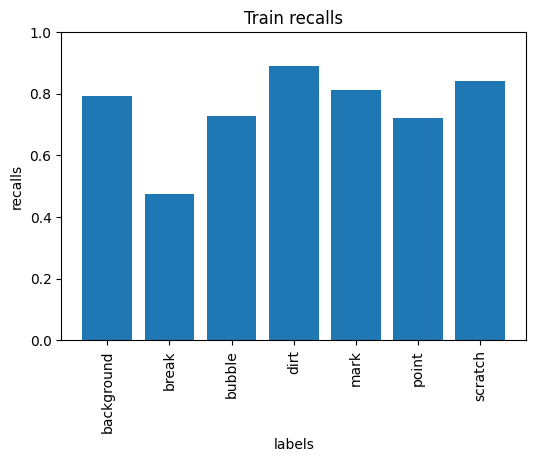

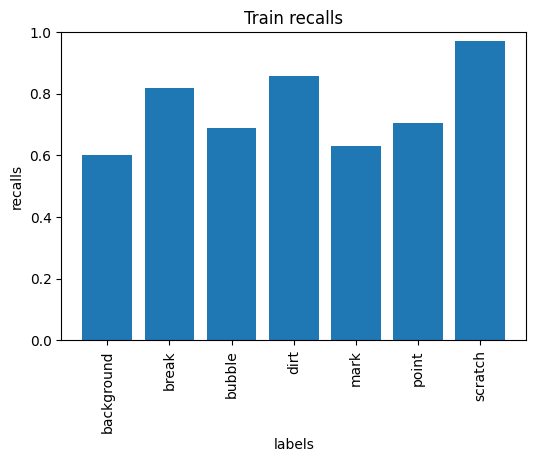

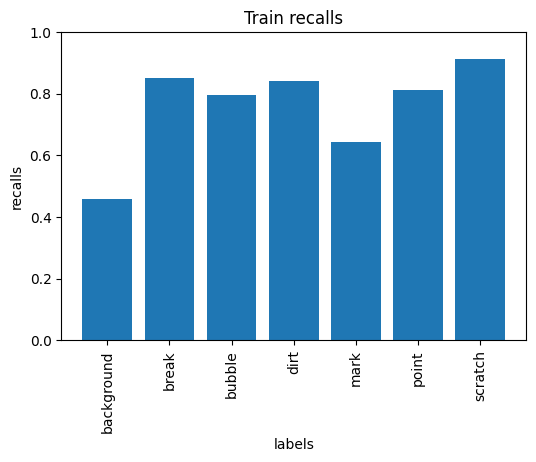

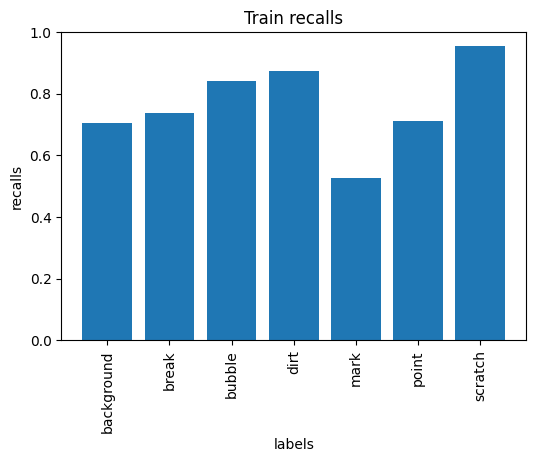

In [42]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

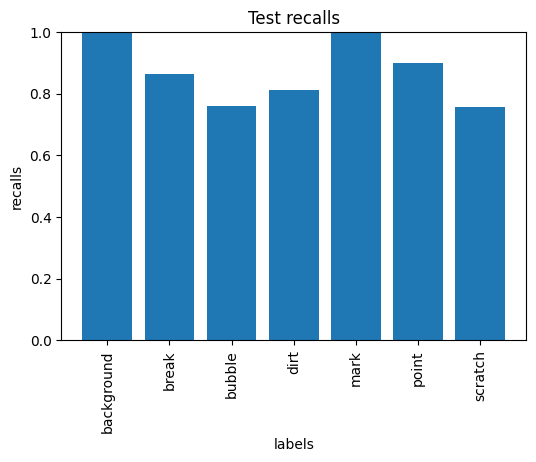

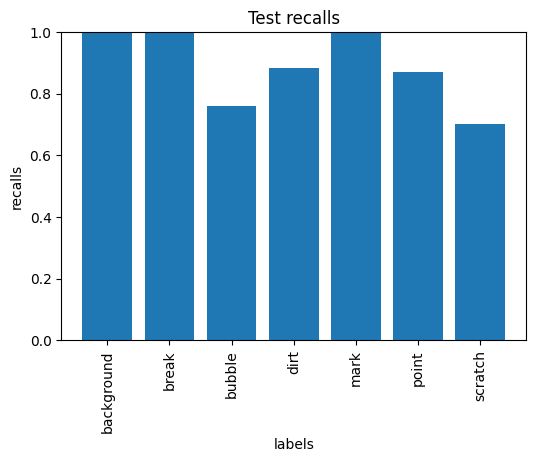

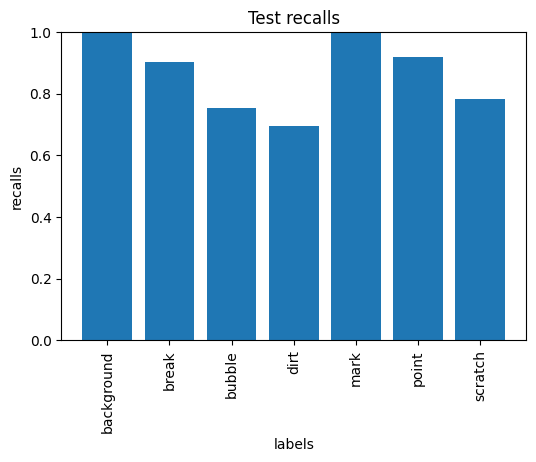

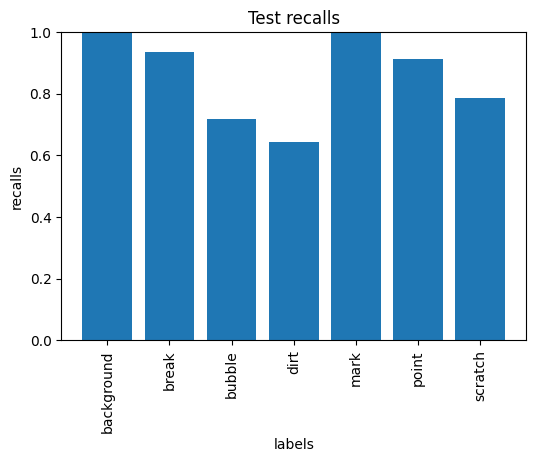

In [43]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

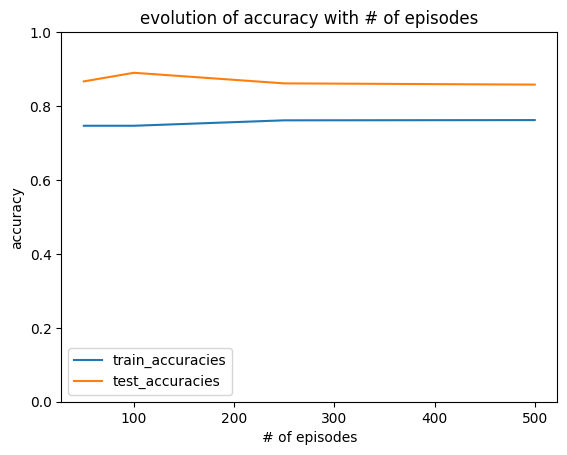

In [44]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (general classes)

In [45]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/')
images_dict = preprocess_images(images_dict, 23, fixed_patch_size)

In [46]:
classes = set(images_classes)
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [47]:
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

# Training and testing on different number of episodes

In [48]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['scratch' 'coating' 'point']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['dirt' 'mark' 'bubble']
Epoch 2 -- Loss: 0.0313 Acc: 0.0333
K: ['mark' 'break' 'dirt']
Epoch 3 -- Loss: 0.0313 Acc: 0.0533
K: ['dust' 'altro' 'bubble']
Epoch 4 -- Loss: 1.4538 Acc: 0.0600
K: ['glass' 'mark' 'altro']
Epoch 5 -- Loss: 3.7943 Acc: 0.0733
K: ['glass' 'dirt' 'scratch']
Epoch 6 -- Loss: 12.9121 Acc: 0.0867
K: ['bubble' 'mark' 'altro']
Epoch 7 -- Loss: 18.1353 Acc: 0.1000
K: ['halo' 'dirt' 'point']
Epoch 8 -- Loss: 19.1092 Acc: 0.1067
K: ['scratch' 'halo' 'altro']
Epoch 9 -- Loss: 20.1086 Acc: 0.1133
K: ['dirt' 'scratch' 'point']
Epoch 10 -- Loss: 21.3080 Acc: 0.1267
K: ['glass' 'point' 'coating']
Epoch 11 -- Loss: 21.3080 Acc: 0.1467
K: ['halo' 'scratch' 'altro']
Epoch 12 -- Loss: 21.8941 Acc: 0.1533
K: ['break' 'scratch' 'halo']
Epoch 13 -- Loss: 26.5622 Acc: 0.1667
K: ['mark' 'bubble' 'break']
Epoch 14 -- Loss: 27.2951 Acc: 0.1800
K: ['bubble' 'dust' 'dirt']
Epoch 15 -- Loss: 29.6160 Acc: 0.1933
K: ['

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'coating' 'dirt']
K: ['altro' 'break' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['glass' 'point' 'bubble']
K: ['mark' 'halo' 'point']
K: ['point' 'coating' 'mark']
K: ['glass' 'halo' 'altro']
K: ['altro' 'bubble' 'break']
K: ['coating' 'mark' 'dust']
K: ['dust' 'altro' 'halo']
K: ['mark' 'scratch' 'break']
K: ['coating' 'bubble' 'dirt']
K: ['break' 'coating' 'scratch']
K: ['mark' 'glass' 'break']
K: ['bubble' 'glass' 'scratch']
K: ['scratch' 'dirt' 'bubble']
K: ['dust' 'scratch' 'halo']
K: ['mark' 'halo' 'break']
K: ['dust' 'coating' 'altro']
K: ['dirt' 'halo' 'scratch']
K: ['altro' 'glass' 'bubble']
K: ['dirt' 'break' 'halo']
K: ['mark' 'glass' 'coating']
K: ['mark' 'dust' 'altro']
K: ['coating' 'bubble' 'glass']
K: ['halo' 'point' 'dust']
K: ['halo' 'break' 'dust']
K: ['break' 'scratch' 'glass']
K: ['glass' 'break' 'scratch']
K: ['altro' 'dust' 'scratch']
K: ['point' 'dust' 'scratch']
K: ['coating' 'dust' 'glass']
K: ['dust' 'altro' 'break']
K: ['dust' 'scratch' 'glass']

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'dust' 'glass']
Epoch 1 -- Loss: 0.0000 Acc: 0.0100
K: ['scratch' 'dust' 'point']
Epoch 2 -- Loss: 0.2146 Acc: 0.0167
K: ['halo' 'scratch' 'altro']
Epoch 3 -- Loss: 1.9422 Acc: 0.0167
K: ['bubble' 'glass' 'halo']
Epoch 4 -- Loss: 1.9422 Acc: 0.0267
K: ['bubble' 'dirt' 'altro']
Epoch 5 -- Loss: 2.7935 Acc: 0.0333
K: ['altro' 'dust' 'mark']
Epoch 6 -- Loss: 3.6530 Acc: 0.0333
K: ['dust' 'break' 'altro']
Epoch 7 -- Loss: 4.0320 Acc: 0.0400
K: ['bubble' 'break' 'glass']
Epoch 8 -- Loss: 4.3390 Acc: 0.0467
K: ['coating' 'mark' 'point']
Epoch 9 -- Loss: 4.3390 Acc: 0.0567
K: ['altro' 'glass' 'dust']
Epoch 10 -- Loss: 4.4889 Acc: 0.0600
K: ['dust' 'halo' 'coating']
Epoch 11 -- Loss: 4.6743 Acc: 0.0667
K: ['coating' 'dust' 'break']
Epoch 12 -- Loss: 5.1658 Acc: 0.0733
K: ['dirt' 'coating' 'bubble']
Epoch 13 -- Loss: 6.7272 Acc: 0.0767
K: ['dirt' 'break' 'point']
Epoch 14 -- Loss: 6.8604 Acc: 0.0833
K: ['altro' 'mark' 'bubble']
Epoch 15 -- Loss: 7.6663 Acc: 0.0900
K: ['bubble' 'dir

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'dust' 'coating']
K: ['scratch' 'dirt' 'dust']
K: ['break' 'point' 'coating']
K: ['dust' 'coating' 'break']
K: ['glass' 'altro' 'dust']
K: ['dirt' 'scratch' 'dust']
K: ['scratch' 'bubble' 'dust']
K: ['point' 'altro' 'coating']
K: ['dust' 'mark' 'break']
K: ['dust' 'break' 'dirt']
K: ['mark' 'dirt' 'coating']
K: ['break' 'halo' 'dust']
K: ['dust' 'break' 'halo']
K: ['dirt' 'scratch' 'glass']
K: ['dirt' 'scratch' 'glass']
K: ['scratch' 'halo' 'altro']
K: ['mark' 'coating' 'altro']
K: ['coating' 'dirt' 'altro']
K: ['dust' 'altro' 'halo']
K: ['glass' 'break' 'point']
K: ['dust' 'dirt' 'coating']
K: ['scratch' 'altro' 'mark']
K: ['halo' 'dust' 'break']
K: ['glass' 'scratch' 'break']
K: ['dirt' 'glass' 'mark']
K: ['point' 'break' 'altro']
K: ['point' 'glass' 'halo']
K: ['point' 'dust' 'bubble']
K: ['bubble' 'coating' 'halo']
K: ['scratch' 'coating' 'dirt']
K: ['glass' 'point' 'break']
K: ['halo' 'glass' 'dust']
K: ['point' 'bubble' 'scratch']
K: ['point' 'altro' 'dirt']
K: ['mar

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'coating' 'point']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['break' 'mark' 'dust']
Epoch 2 -- Loss: 0.0000 Acc: 0.0080
K: ['dust' 'point' 'coating']
Epoch 3 -- Loss: 0.0000 Acc: 0.0120
K: ['point' 'break' 'bubble']
Epoch 4 -- Loss: 0.0000 Acc: 0.0160
K: ['halo' 'mark' 'bubble']
Epoch 5 -- Loss: 1.1414 Acc: 0.0187
K: ['point' 'bubble' 'altro']
Epoch 6 -- Loss: 1.6608 Acc: 0.0213
K: ['glass' 'point' 'coating']
Epoch 7 -- Loss: 1.6608 Acc: 0.0253
K: ['altro' 'coating' 'halo']
Epoch 8 -- Loss: 1.7814 Acc: 0.0280
K: ['dust' 'scratch' 'bubble']
Epoch 9 -- Loss: 2.4025 Acc: 0.0307
K: ['point' 'dirt' 'break']
Epoch 10 -- Loss: 2.4025 Acc: 0.0347
K: ['coating' 'halo' 'mark']
Epoch 11 -- Loss: 2.4731 Acc: 0.0373
K: ['break' 'scratch' 'dust']
Epoch 12 -- Loss: 2.5571 Acc: 0.0400
K: ['halo' 'break' 'dust']
Epoch 13 -- Loss: 2.9033 Acc: 0.0413
K: ['point' 'altro' 'dirt']
Epoch 14 -- Loss: 3.0423 Acc: 0.0440
K: ['dirt' 'scratch' 'bubble']
Epoch 15 -- Loss: 3.4640 Acc: 0.0467
K: ['coating' 

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['halo' 'dust' 'glass']
K: ['break' 'bubble' 'point']
K: ['break' 'scratch' 'coating']
K: ['altro' 'mark' 'glass']
K: ['bubble' 'halo' 'dust']
K: ['break' 'point' 'dirt']
K: ['mark' 'break' 'glass']
K: ['dust' 'point' 'coating']
K: ['break' 'dirt' 'glass']
K: ['mark' 'scratch' 'halo']
K: ['point' 'coating' 'mark']
K: ['break' 'halo' 'point']
K: ['altro' 'dirt' 'mark']
K: ['altro' 'dirt' 'dust']
K: ['dirt' 'coating' 'bubble']
K: ['mark' 'altro' 'point']
K: ['dust' 'halo' 'coating']
K: ['dust' 'coating' 'glass']
K: ['mark' 'dust' 'coating']
K: ['bubble' 'break' 'coating']
K: ['glass' 'scratch' 'dirt']
K: ['coating' 'mark' 'bubble']
K: ['glass' 'altro' 'dust']
K: ['dirt' 'bubble' 'point']
K: ['break' 'point' 'coating']
K: ['dust' 'point' 'coating']
K: ['dust' 'dirt' 'point']
K: ['break' 'dirt' 'halo']
K: ['coating' 'mark' 'dirt']
K: ['mark' 'dirt' 'bubble']
K: ['point' 'bubble' 'halo']
K: ['glass' 'dust' 'bubble']
K: ['dust' 'coating' 'dirt']
K: ['break' 'point' 'bubble']
K: ['glass' '

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['altro' 'halo' 'glass']
Epoch 1 -- Loss: 0.0039 Acc: 0.0013
K: ['scratch' 'dirt' 'mark']
Epoch 2 -- Loss: 0.1154 Acc: 0.0020
K: ['point' 'bubble' 'dirt']
Epoch 3 -- Loss: 0.1426 Acc: 0.0033
K: ['coating' 'scratch' 'halo']
Epoch 4 -- Loss: 0.2501 Acc: 0.0040
K: ['break' 'point' 'scratch']
Epoch 5 -- Loss: 0.3979 Acc: 0.0053
K: ['glass' 'scratch' 'mark']
Epoch 6 -- Loss: 0.4049 Acc: 0.0067
K: ['bubble' 'glass' 'halo']
Epoch 7 -- Loss: 0.4694 Acc: 0.0080
K: ['coating' 'point' 'glass']
Epoch 8 -- Loss: 0.4694 Acc: 0.0100
K: ['glass' 'scratch' 'altro']
Epoch 9 -- Loss: 0.4837 Acc: 0.0113
K: ['dust' 'mark' 'coating']
Epoch 10 -- Loss: 0.6394 Acc: 0.0127
K: ['bubble' 'halo' 'glass']
Epoch 11 -- Loss: 0.6402 Acc: 0.0140
K: ['point' 'scratch' 'dirt']
Epoch 12 -- Loss: 0.7178 Acc: 0.0153
K: ['glass' 'halo' 'altro']
Epoch 13 -- Loss: 0.8756 Acc: 0.0167
K: ['scratch' 'glass' 'point']
Epoch 14 -- Loss: 0.9163 Acc: 0.0180
K: ['altro' 'halo' 'scratch']
Epoch 15 -- Loss: 1.0726 Acc: 0.0187
K: ['gl

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['altro' 'coating' 'halo']
K: ['bubble' 'dust' 'point']
K: ['dust' 'altro' 'bubble']
K: ['coating' 'break' 'altro']
K: ['bubble' 'mark' 'altro']
K: ['altro' 'dirt' 'bubble']
K: ['coating' 'glass' 'scratch']
K: ['halo' 'bubble' 'dirt']
K: ['mark' 'dirt' 'point']
K: ['mark' 'halo' 'coating']
K: ['halo' 'glass' 'scratch']
K: ['altro' 'halo' 'dust']
K: ['halo' 'scratch' 'point']
K: ['scratch' 'mark' 'break']
K: ['point' 'mark' 'dirt']
K: ['altro' 'dust' 'mark']
K: ['bubble' 'dust' 'coating']
K: ['dirt' 'bubble' 'point']
K: ['halo' 'altro' 'bubble']
K: ['mark' 'break' 'glass']
K: ['glass' 'break' 'altro']
K: ['dust' 'point' 'break']
K: ['bubble' 'dust' 'point']
K: ['glass' 'dust' 'altro']
K: ['dust' 'bubble' 'scratch']
K: ['bubble' 'coating' 'mark']
K: ['break' 'bubble' 'mark']
K: ['mark' 'break' 'dirt']
K: ['halo' 'scratch' 'mark']
K: ['dirt' 'coating' 'glass']
K: ['dust' 'bubble' 'coating']
K: ['dust' 'mark' 'coating']
K: ['bubble' 'mark' 'dirt']
K: ['dirt' 'mark' 'altro']
K: ['dust' '

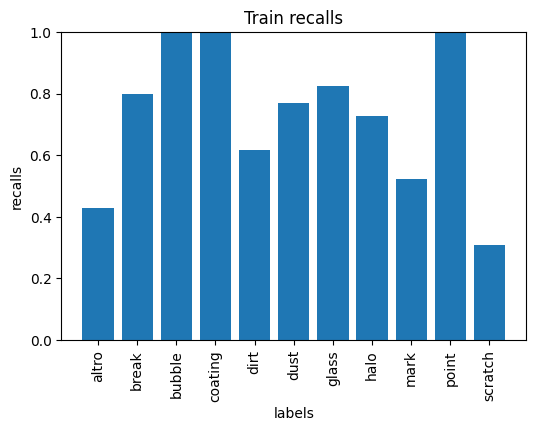

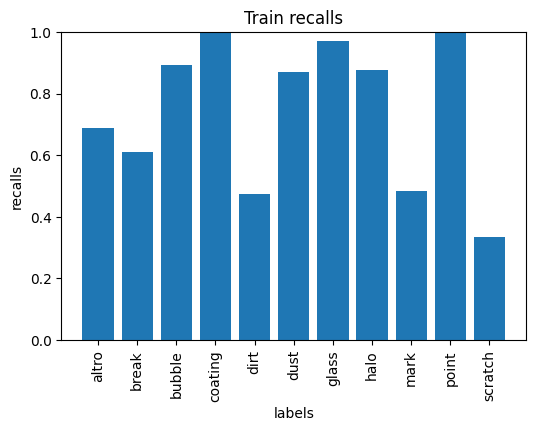

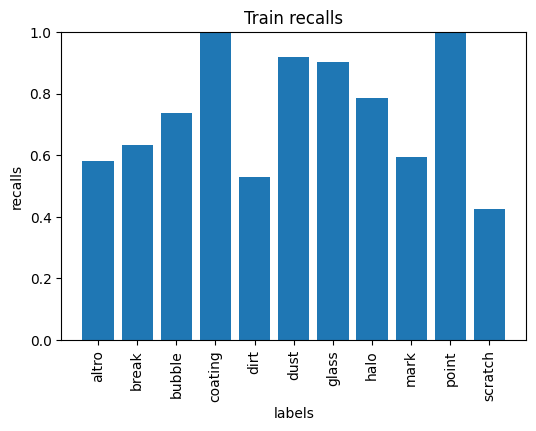

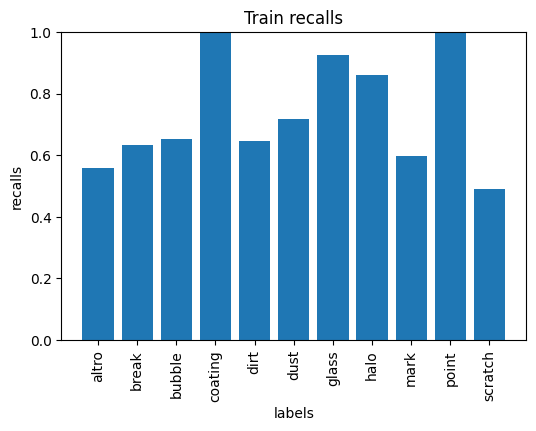

In [49]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

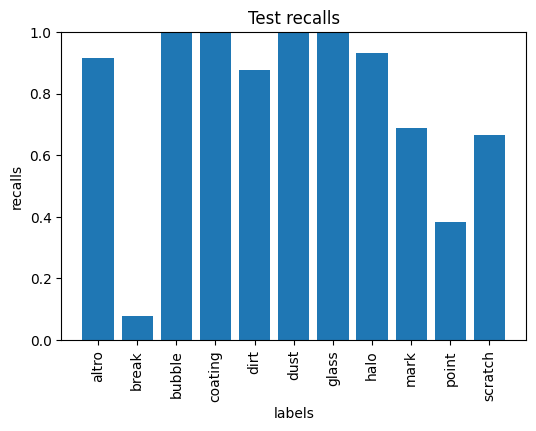

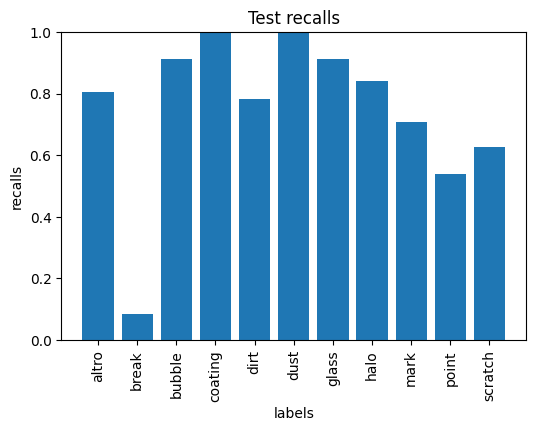

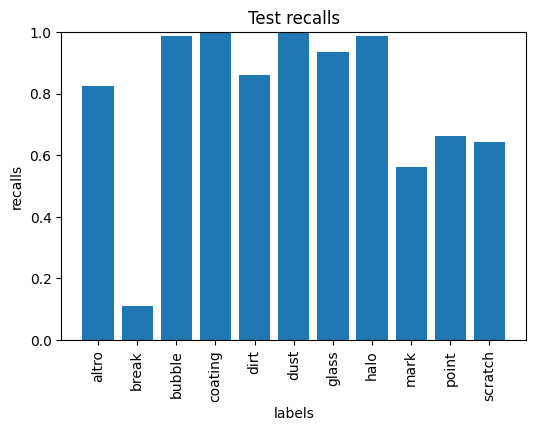

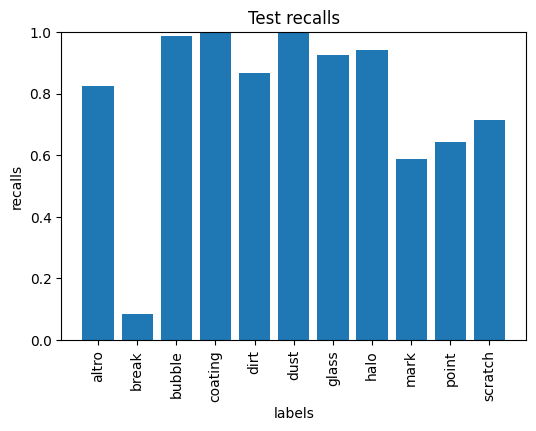

In [50]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

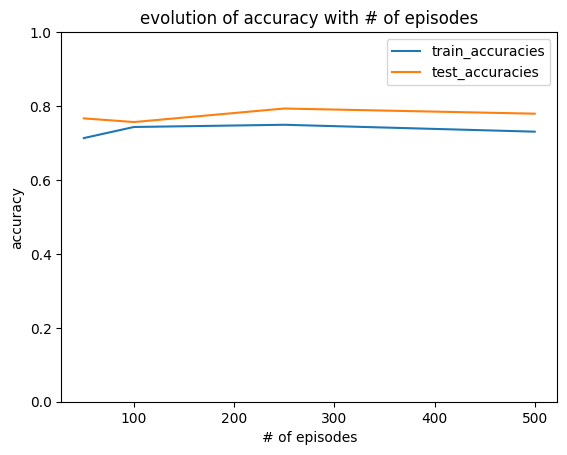

In [51]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (detailed classes)

In [52]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/', '_did_')
images_dict = preprocess_images(images_dict, 23, fixed_patch_size)

In [53]:
classes = set(images_classes)
classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [54]:
classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

# Training and testing on different number of episodes

In [55]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble_hole' 'glass_id' 'scratch_light']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch_multi' 'dirt' 'coating']
Epoch 2 -- Loss: 0.0000 Acc: 0.0400
K: ['glass_id' 'break' 'dirt']
Epoch 3 -- Loss: 0.1560 Acc: 0.0533
K: ['bubble_hole' 'glass_id' 'scratch_multi']
Epoch 4 -- Loss: 0.1560 Acc: 0.0733
K: ['dust' 'scratch_heavy' 'dirt_halo']
Epoch 5 -- Loss: 0.1560 Acc: 0.0933
K: ['bubble' 'halo' 'scratch_heavy']
Epoch 6 -- Loss: 1.0719 Acc: 0.1067
K: ['dirt' 'dust' 'bubble_hole']
Epoch 7 -- Loss: 1.2268 Acc: 0.1200
K: ['dirt_halo' 'scratch_light' 'scratch_multi']
Epoch 8 -- Loss: 1.2268 Acc: 0.1400
K: ['mark' 'dust' 'dirt_halo']
Epoch 9 -- Loss: 3.1055 Acc: 0.1533
K: ['dirt' 'scratch_multi' 'break']
Epoch 10 -- Loss: 4.4805 Acc: 0.1667
K: ['dust' 'scratch_multi' 'point']
Epoch 11 -- Loss: 4.4805 Acc: 0.1867
K: ['bubble_hole' 'altro' 'point']
Epoch 12 -- Loss: 4.9200 Acc: 0.2000
K: ['dust' 'break' 'scratch_multi']
Epoch 13 -- Loss: 4.9200 Acc: 0.2200
K: ['bubble' 'dirt' 'mark']
Epoch 

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'halo' 'mark']
K: ['coating' 'break' 'scratch_light']
K: ['coating' 'bubble_hole' 'point']
K: ['coating' 'break' 'point']
K: ['break' 'bubble_hole' 'scratch_multi']
K: ['scratch_multi' 'scratch_light' 'halo']
K: ['dust' 'mark' 'dirt_halo']
K: ['scratch_light' 'point' 'dirt_halo']
K: ['scratch_multi' 'scratch_heavy' 'altro']
K: ['scratch_heavy' 'dust' 'dirt']
K: ['mark' 'bubble_hole' 'scratch_light']
K: ['halo' 'bubble_hole' 'point']
K: ['dirt' 'mark' 'break']
K: ['glass_id' 'bubble_hole' 'scratch_multi']
K: ['scratch_light' 'break' 'dirt_halo']
K: ['point' 'scratch_heavy' 'dust']
K: ['glass_id' 'altro' 'bubble_hole']
K: ['bubble' 'scratch_multi' 'mark']
K: ['coating' 'glass_id' 'break']
K: ['dirt' 'scratch_heavy' 'bubble']
K: ['scratch_light' 'bubble_hole' 'halo']
K: ['scratch_light' 'bubble_hole' 'scratch_heavy']
K: ['scratch_heavy' 'dirt' 'halo']
K: ['dirt' 'point' 'mark']
K: ['scratch_heavy' 'coating' 'dirt_halo']
K: ['glass_id' 'halo' 'scratch_multi']
K: ['dirt' 'point'

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'altro' 'coating']
Epoch 1 -- Loss: 0.0000 Acc: 0.0100
K: ['scratch_multi' 'altro' 'mark']
Epoch 2 -- Loss: 0.0019 Acc: 0.0200
K: ['scratch_heavy' 'scratch_multi' 'mark']
Epoch 3 -- Loss: 1.5293 Acc: 0.0200
K: ['glass_id' 'altro' 'bubble_hole']
Epoch 4 -- Loss: 1.5297 Acc: 0.0300
K: ['halo' 'scratch_light' 'bubble']
Epoch 5 -- Loss: 2.8062 Acc: 0.0333
K: ['dust' 'dirt_halo' 'scratch_heavy']
Epoch 6 -- Loss: 4.1703 Acc: 0.0400
K: ['mark' 'point' 'bubble_hole']
Epoch 7 -- Loss: 4.3221 Acc: 0.0467
K: ['glass_id' 'dirt' 'dirt_halo']
Epoch 8 -- Loss: 4.3221 Acc: 0.0567
K: ['halo' 'coating' 'scratch_heavy']
Epoch 9 -- Loss: 4.3221 Acc: 0.0667
K: ['dirt' 'glass_id' 'point']
Epoch 10 -- Loss: 4.3221 Acc: 0.0767
K: ['scratch_light' 'point' 'dirt_halo']
Epoch 11 -- Loss: 6.8235 Acc: 0.0833
K: ['dirt' 'scratch_light' 'dirt_halo']
Epoch 12 -- Loss: 7.7239 Acc: 0.0900
K: ['scratch_multi' 'bubble' 'bubble_hole']
Epoch 13 -- Loss: 7.7239 Acc: 0.1000
K: ['halo' 'point' 'scratch_heavy']
Epo

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['break' 'dirt_halo' 'dust']
K: ['dirt_halo' 'dust' 'point']
K: ['dirt_halo' 'scratch_multi' 'bubble']
K: ['altro' 'coating' 'dirt']
K: ['break' 'altro' 'dust']
K: ['break' 'point' 'scratch_multi']
K: ['coating' 'dirt' 'glass_id']
K: ['bubble' 'point' 'scratch_light']
K: ['glass_id' 'scratch_light' 'altro']
K: ['break' 'dust' 'altro']
K: ['coating' 'point' 'dust']
K: ['dust' 'scratch_light' 'mark']
K: ['bubble' 'break' 'coating']
K: ['halo' 'dust' 'scratch_light']
K: ['glass_id' 'break' 'halo']
K: ['break' 'glass_id' 'bubble']
K: ['break' 'scratch_multi' 'coating']
K: ['scratch_light' 'point' 'halo']
K: ['scratch_light' 'scratch_heavy' 'coating']
K: ['scratch_multi' 'dust' 'break']
K: ['halo' 'scratch_heavy' 'dust']
K: ['coating' 'break' 'mark']
K: ['dust' 'scratch_multi' 'bubble_hole']
K: ['dust' 'dirt_halo' 'altro']
K: ['scratch_multi' 'point' 'dirt']
K: ['mark' 'halo' 'point']
K: ['halo' 'bubble_hole' 'glass_id']
K: ['altro' 'point' 'scratch_heavy']
K: ['mark' 'bubble' 'glass_id'

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['bubble_hole' 'scratch_multi' 'dirt_halo']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['point' 'break' 'altro']
Epoch 2 -- Loss: 0.4106 Acc: 0.0067
K: ['break' 'altro' 'dust']
Epoch 3 -- Loss: 0.6260 Acc: 0.0080
K: ['glass_id' 'dirt_halo' 'bubble']
Epoch 4 -- Loss: 0.8639 Acc: 0.0107
K: ['scratch_light' 'point' 'dust']
Epoch 5 -- Loss: 0.9287 Acc: 0.0133
K: ['altro' 'break' 'scratch_light']
Epoch 6 -- Loss: 0.9564 Acc: 0.0147
K: ['coating' 'dirt' 'dirt_halo']
Epoch 7 -- Loss: 0.9564 Acc: 0.0187
K: ['altro' 'bubble' 'scratch_multi']
Epoch 8 -- Loss: 1.1085 Acc: 0.0213
K: ['bubble_hole' 'glass_id' 'halo']
Epoch 9 -- Loss: 1.1085 Acc: 0.0253
K: ['halo' 'scratch_multi' 'point']
Epoch 10 -- Loss: 1.1085 Acc: 0.0293
K: ['bubble' 'point' 'scratch_heavy']
Epoch 11 -- Loss: 1.2444 Acc: 0.0320
K: ['dirt' 'mark' 'scratch_heavy']
Epoch 12 -- Loss: 2.2378 Acc: 0.0320
K: ['glass_id' 'dirt' 'dust']
Epoch 13 -- Loss: 2.3613 Acc: 0.0333
K: ['scratch_heavy' 'scratch_multi' 'altro']
Epoch 14 -- Loss: 2.6

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['dust' 'dirt_halo' 'bubble_hole']
K: ['scratch_multi' 'dirt_halo' 'point']
K: ['mark' 'scratch_heavy' 'dirt']
K: ['bubble' 'dirt' 'glass_id']
K: ['dirt_halo' 'bubble_hole' 'scratch_multi']
K: ['dust' 'glass_id' 'dirt_halo']
K: ['mark' 'dirt' 'break']
K: ['mark' 'bubble' 'glass_id']
K: ['coating' 'scratch_light' 'scratch_multi']
K: ['dirt_halo' 'altro' 'dust']
K: ['coating' 'dirt_halo' 'halo']
K: ['break' 'point' 'halo']
K: ['break' 'scratch_multi' 'dirt']
K: ['bubble_hole' 'mark' 'dust']
K: ['break' 'dust' 'altro']
K: ['bubble' 'point' 'glass_id']
K: ['scratch_multi' 'point' 'coating']
K: ['scratch_light' 'break' 'glass_id']
K: ['point' 'dirt_halo' 'scratch_heavy']
K: ['coating' 'glass_id' 'bubble']
K: ['coating' 'scratch_heavy' 'halo']
K: ['break' 'glass_id' 'mark']
K: ['dust' 'coating' 'point']
K: ['dirt_halo' 'dust' 'break']
K: ['glass_id' 'break' 'bubble']
K: ['bubble' 'point' 'dirt_halo']
K: ['point' 'altro' 'break']
K: ['glass_id' 'point' 'mark']
K: ['scratch_heavy' 'mark' 'd

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'scratch_light' 'bubble_hole']
Epoch 1 -- Loss: 0.0000 Acc: 0.0020
K: ['point' 'mark' 'bubble']
Epoch 2 -- Loss: 0.0973 Acc: 0.0027
K: ['mark' 'coating' 'dirt']
Epoch 3 -- Loss: 0.1657 Acc: 0.0040
K: ['scratch_multi' 'dirt' 'halo']
Epoch 4 -- Loss: 0.2940 Acc: 0.0053
K: ['scratch_multi' 'coating' 'scratch_light']
Epoch 5 -- Loss: 0.2940 Acc: 0.0073
K: ['coating' 'bubble' 'halo']
Epoch 6 -- Loss: 0.2941 Acc: 0.0093
K: ['point' 'bubble' 'dust']
Epoch 7 -- Loss: 0.2941 Acc: 0.0113
K: ['coating' 'dirt_halo' 'dirt']
Epoch 8 -- Loss: 0.2941 Acc: 0.0133
K: ['break' 'scratch_light' 'dirt_halo']
Epoch 9 -- Loss: 0.4037 Acc: 0.0147
K: ['dust' 'dirt' 'coating']
Epoch 10 -- Loss: 0.4037 Acc: 0.0167
K: ['halo' 'glass_id' 'coating']
Epoch 11 -- Loss: 0.4037 Acc: 0.0187
K: ['mark' 'scratch_light' 'bubble_hole']
Epoch 12 -- Loss: 0.4037 Acc: 0.0207
K: ['break' 'bubble_hole' 'dirt_halo']
Epoch 13 -- Loss: 0.4037 Acc: 0.0227
K: ['break' 'bubble_hole' 'point']
Epoch 14 -- Loss: 0.4037 Acc: 0

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['halo' 'point' 'mark']
K: ['bubble_hole' 'halo' 'dirt_halo']
K: ['halo' 'glass_id' 'dirt']
K: ['point' 'coating' 'scratch_heavy']
K: ['halo' 'dust' 'coating']
K: ['altro' 'bubble_hole' 'point']
K: ['break' 'scratch_light' 'scratch_heavy']
K: ['bubble' 'dirt' 'scratch_heavy']
K: ['dirt' 'break' 'coating']
K: ['glass_id' 'bubble' 'scratch_multi']
K: ['dirt' 'dust' 'scratch_multi']
K: ['halo' 'scratch_multi' 'break']
K: ['dirt' 'dirt_halo' 'dust']
K: ['dirt_halo' 'dirt' 'altro']
K: ['dirt' 'bubble' 'mark']
K: ['altro' 'glass_id' 'dirt_halo']
K: ['altro' 'mark' 'point']
K: ['break' 'dirt' 'dirt_halo']
K: ['scratch_light' 'point' 'altro']
K: ['coating' 'scratch_light' 'point']
K: ['glass_id' 'bubble_hole' 'break']
K: ['bubble' 'dirt_halo' 'point']
K: ['break' 'bubble' 'scratch_light']
K: ['scratch_multi' 'break' 'coating']
K: ['scratch_heavy' 'scratch_light' 'halo']
K: ['break' 'scratch_multi' 'halo']
K: ['coating' 'bubble_hole' 'point']
K: ['dirt_halo' 'break' 'glass_id']
K: ['coating'

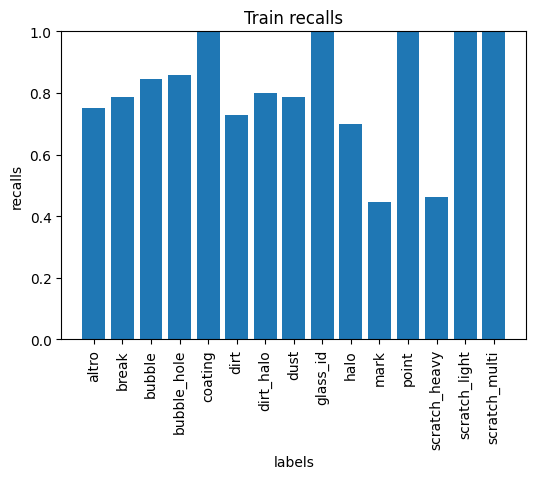

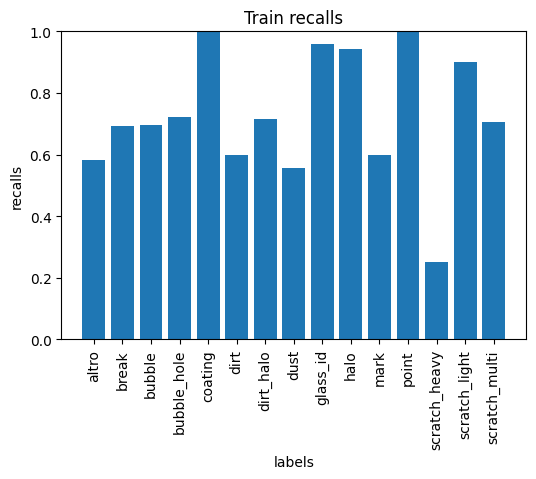

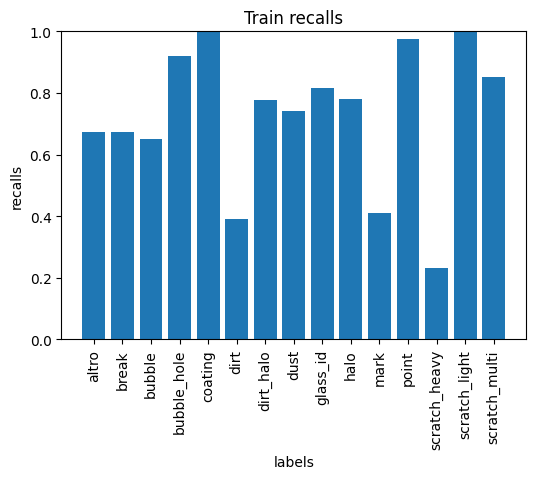

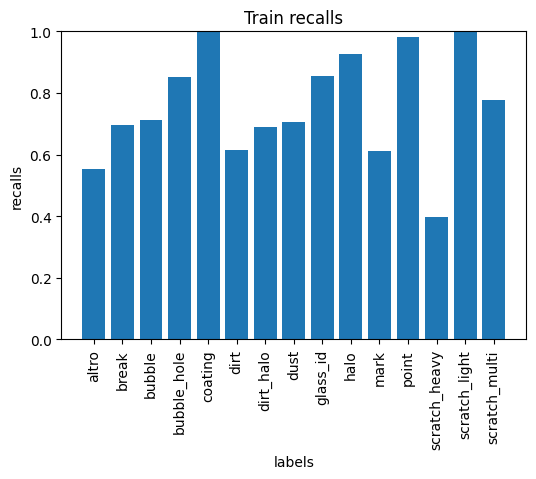

In [56]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

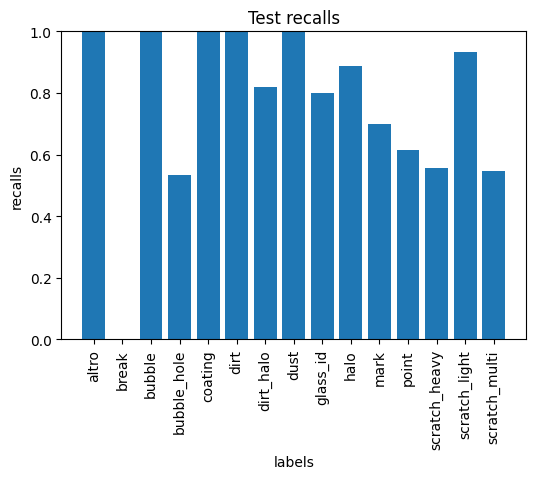

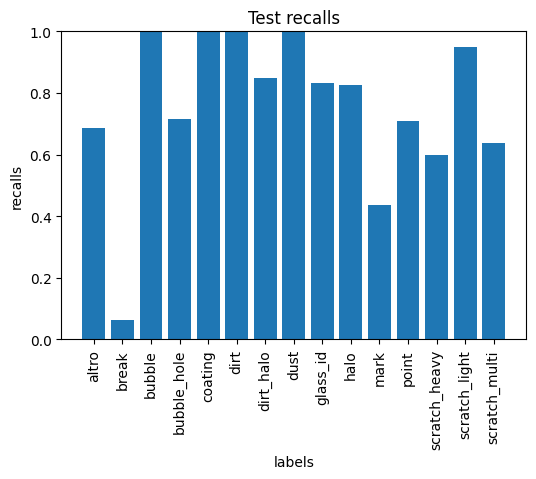

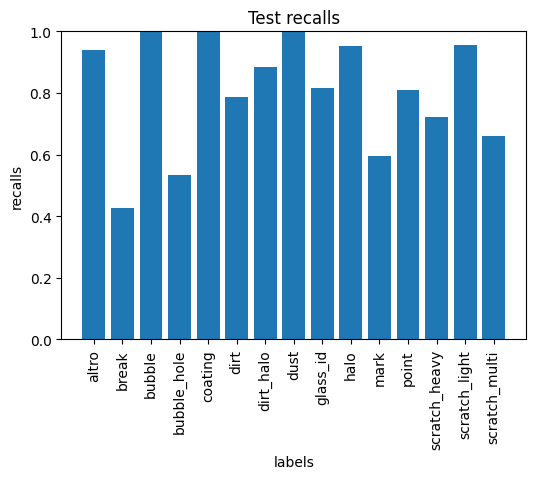

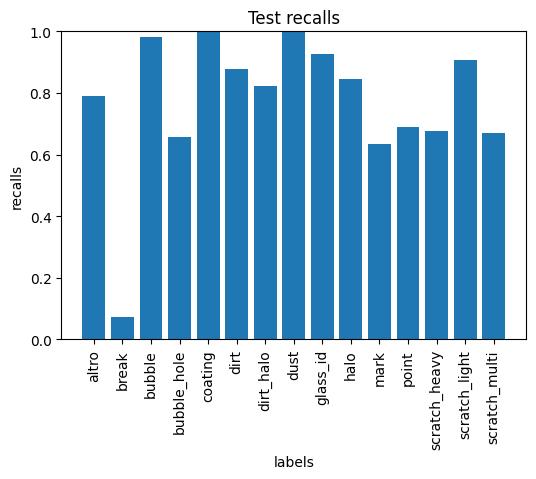

In [57]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

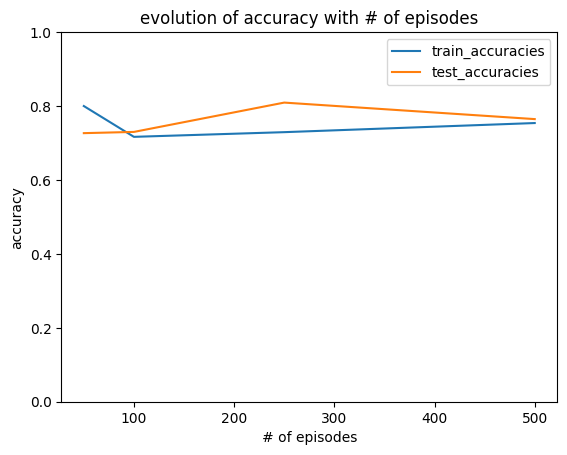

In [58]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset to predict opt_bckg

In [59]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/')
train_images_dict = preprocess_images(train_images_dict, 23, fixed_patch_size)

In [60]:
train_classes = set(train_images_classes)
train_classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [61]:
train_target_classes = extend_target_classes(train_images_classes, 4)

In [62]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')
test_images_dict = preprocess_images(test_images_dict, 26, fixed_patch_size)

In [63]:
test_classes = set(test_images_classes)
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [64]:
test_target_classes = extend_target_classes(test_images_classes, 4)

In [65]:
increased_episodes = [50, 100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

model = load_protonet_conv(
    x_dim=(3,fixed_patch_size,fixed_patch_size),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 3, 1, 1, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'break' 'bubble']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['point' 'dirt' 'scratch']
Epoch 2 -- Loss: 2.7149 Acc: 0.0333
K: ['bubble' 'halo' 'dust']
Epoch 3 -- Loss: 2.8318 Acc: 0.0467
K: ['dust' 'dirt' 'altro']
Epoch 4 -- Loss: 6.3663 Acc: 0.0533
K: ['scratch' 'dirt' 'coating']
Epoch 5 -- Loss: 6.3663 Acc: 0.0733
K: ['mark' 'glass' 'dirt']
Epoch 6 -- Loss: 9.0796 Acc: 0.0867
K: ['glass' 'bubble' 'coating']
Epoch 7 -- Loss: 9.0796 Acc: 0.1067
K: ['bubble' 'dust' 'dirt']
Epoch 8 -- Loss: 10.1762 Acc: 0.1200
K: ['break' 'mark' 'scratch']
Epoch 9 -- Loss: 13.8386 Acc: 0.1267
K: ['point' 'break' 'scratch']
Epoch 10 -- Loss: 13.8386 Acc: 0.1467
K: ['halo' 'dirt' 'glass']
Epoch 11 -- Loss: 14.0483 Acc: 0.1600
K: ['dust' 'bubble' 'dirt']
Epoch 12 -- Loss: 16.8395 Acc: 0.1733
K: ['halo' 'bubble' 'dust']
Epoch 13 -- Loss: 16.8525 Acc: 0.1867
K: ['break' 'point' 'bubble']
Epoch 14 -- Loss: 18.2228 Acc: 0.2000
K: ['altro' 'mark' 'break']
Epoch 15 -- Loss: 18.2228 Acc: 0.2200
K: ['coati

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt' 'background' 'scratch']
K: ['break' 'bubble' 'mark']
K: ['break' 'background' 'scratch']
K: ['background' 'break' 'scratch']
K: ['bubble' 'break' 'background']
K: ['scratch' 'background' 'mark']
K: ['point' 'background' 'mark']
K: ['point' 'scratch' 'background']
K: ['mark' 'break' 'dirt']
K: ['mark' 'scratch' 'break']
K: ['mark' 'bubble' 'point']
K: ['scratch' 'mark' 'break']
K: ['bubble' 'break' 'mark']
K: ['scratch' 'point' 'dirt']
K: ['dirt' 'background' 'scratch']
K: ['dirt' 'point' 'break']
K: ['break' 'background' 'point']
K: ['scratch' 'point' 'break']
K: ['background' 'break' 'dirt']
K: ['background' 'mark' 'scratch']
K: ['point' 'mark' 'dirt']
K: ['scratch' 'point' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['scratch' 'bubble' 'point']
K: ['break' 'background' 'bubble']
K: ['background' 'mark' 'point']
K: ['bubble' 'break' 'dirt']
K: ['background' 'break' 'scratch']
K: ['dirt' 'mark' 'break']
K: ['break' 'background' 'point']
K: ['mark' 'bubble' 'break']
K: ['dirt'

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['mark' 'dust' 'break']
Epoch 1 -- Loss: 0.4005 Acc: 0.0033
K: ['scratch' 'altro' 'point']
Epoch 2 -- Loss: 0.5524 Acc: 0.0100
K: ['scratch' 'glass' 'mark']
Epoch 3 -- Loss: 0.5524 Acc: 0.0200
K: ['scratch' 'point' 'mark']
Epoch 4 -- Loss: 0.9615 Acc: 0.0267
K: ['glass' 'break' 'point']
Epoch 5 -- Loss: 0.9615 Acc: 0.0367
K: ['halo' 'point' 'break']
Epoch 6 -- Loss: 2.3593 Acc: 0.0400
K: ['break' 'bubble' 'glass']
Epoch 7 -- Loss: 2.5775 Acc: 0.0467
K: ['bubble' 'mark' 'scratch']
Epoch 8 -- Loss: 4.5973 Acc: 0.0500
K: ['dust' 'coating' 'bubble']
Epoch 9 -- Loss: 4.5973 Acc: 0.0600
K: ['break' 'bubble' 'glass']
Epoch 10 -- Loss: 4.5973 Acc: 0.0700
K: ['bubble' 'mark' 'dirt']
Epoch 11 -- Loss: 5.0495 Acc: 0.0700
K: ['altro' 'glass' 'coating']
Epoch 12 -- Loss: 5.0496 Acc: 0.0800
K: ['mark' 'halo' 'dirt']
Epoch 13 -- Loss: 5.0496 Acc: 0.0900
K: ['coating' 'point' 'glass']
Epoch 14 -- Loss: 5.0531 Acc: 0.0967
K: ['break' 'bubble' 'altro']
Epoch 15 -- Loss: 5.0588 Acc: 0.1033
K: ['mark' 

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['break' 'dirt' 'background']
K: ['background' 'bubble' 'break']
K: ['point' 'scratch' 'break']
K: ['point' 'dirt' 'scratch']
K: ['background' 'point' 'break']
K: ['background' 'bubble' 'scratch']
K: ['bubble' 'scratch' 'dirt']
K: ['dirt' 'break' 'mark']
K: ['bubble' 'dirt' 'point']
K: ['scratch' 'point' 'break']
K: ['scratch' 'dirt' 'bubble']
K: ['mark' 'bubble' 'point']
K: ['dirt' 'mark' 'point']
K: ['point' 'scratch' 'mark']
K: ['dirt' 'mark' 'break']
K: ['bubble' 'scratch' 'point']
K: ['dirt' 'mark' 'scratch']
K: ['dirt' 'background' 'mark']
K: ['bubble' 'scratch' 'break']
K: ['scratch' 'point' 'bubble']
K: ['bubble' 'break' 'scratch']
K: ['scratch' 'bubble' 'mark']
K: ['break' 'bubble' 'mark']
K: ['point' 'scratch' 'background']
K: ['dirt' 'scratch' 'mark']
K: ['point' 'bubble' 'scratch']
K: ['background' 'point' 'mark']
K: ['point' 'background' 'dirt']
K: ['break' 'mark' 'scratch']
K: ['scratch' 'background' 'bubble']
K: ['break' 'scratch' 'dirt']
K: ['background' 'dirt' 'brea

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['halo' 'scratch' 'point']
Epoch 1 -- Loss: 0.2680 Acc: 0.0013
K: ['break' 'halo' 'altro']
Epoch 2 -- Loss: 0.3067 Acc: 0.0040
K: ['scratch' 'dirt' 'halo']
Epoch 3 -- Loss: 0.4105 Acc: 0.0053
K: ['coating' 'altro' 'halo']
Epoch 4 -- Loss: 0.4620 Acc: 0.0080
K: ['break' 'dust' 'coating']
Epoch 5 -- Loss: 0.4620 Acc: 0.0120
K: ['glass' 'coating' 'halo']
Epoch 6 -- Loss: 0.4620 Acc: 0.0160
K: ['dust' 'point' 'mark']
Epoch 7 -- Loss: 0.8517 Acc: 0.0173
K: ['glass' 'break' 'dust']
Epoch 8 -- Loss: 0.8517 Acc: 0.0213
K: ['halo' 'altro' 'dust']
Epoch 9 -- Loss: 0.8743 Acc: 0.0240
K: ['dust' 'dirt' 'altro']
Epoch 10 -- Loss: 1.0312 Acc: 0.0253
K: ['break' 'glass' 'halo']
Epoch 11 -- Loss: 1.1826 Acc: 0.0280
K: ['dust' 'coating' 'glass']
Epoch 12 -- Loss: 1.1826 Acc: 0.0320
K: ['point' 'glass' 'mark']
Epoch 13 -- Loss: 1.1826 Acc: 0.0360
K: ['point' 'glass' 'dust']
Epoch 14 -- Loss: 1.2646 Acc: 0.0387
K: ['glass' 'break' 'scratch']
Epoch 15 -- Loss: 1.3621 Acc: 0.0413
K: ['mark' 'break' 'gla

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'break' 'point']
K: ['bubble' 'background' 'point']
K: ['scratch' 'dirt' 'mark']
K: ['background' 'scratch' 'mark']
K: ['scratch' 'background' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['background' 'dirt' 'break']
K: ['mark' 'point' 'scratch']
K: ['point' 'break' 'bubble']
K: ['mark' 'point' 'break']
K: ['scratch' 'mark' 'dirt']
K: ['break' 'background' 'mark']
K: ['point' 'break' 'background']
K: ['mark' 'break' 'dirt']
K: ['point' 'bubble' 'background']
K: ['bubble' 'dirt' 'scratch']
K: ['background' 'point' 'break']
K: ['bubble' 'point' 'background']
K: ['dirt' 'scratch' 'break']
K: ['point' 'break' 'background']
K: ['break' 'dirt' 'mark']
K: ['mark' 'point' 'dirt']
K: ['bubble' 'scratch' 'break']
K: ['mark' 'background' 'scratch']
K: ['scratch' 'bubble' 'break']
K: ['point' 'bubble' 'mark']
K: ['background' 'break' 'bubble']
K: ['background' 'break' 'mark']
K: ['background' 'point' 'bubble']
K: ['background' 'mark' 'scratch']
K: ['scratch' 'point' 'dirt']
K: ['break' '

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['glass' 'dirt' 'mark']
Epoch 1 -- Loss: 0.0389 Acc: 0.0013
K: ['scratch' 'altro' 'dust']
Epoch 2 -- Loss: 0.1644 Acc: 0.0027
K: ['scratch' 'coating' 'dust']
Epoch 3 -- Loss: 0.1644 Acc: 0.0047
K: ['break' 'mark' 'bubble']
Epoch 4 -- Loss: 0.1729 Acc: 0.0060
K: ['glass' 'break' 'dirt']
Epoch 5 -- Loss: 0.1729 Acc: 0.0080
K: ['scratch' 'halo' 'dust']
Epoch 6 -- Loss: 0.2522 Acc: 0.0087
K: ['bubble' 'dirt' 'glass']
Epoch 7 -- Loss: 0.4004 Acc: 0.0100
K: ['glass' 'halo' 'dust']
Epoch 8 -- Loss: 0.4188 Acc: 0.0107
K: ['halo' 'dirt' 'bubble']
Epoch 9 -- Loss: 0.4188 Acc: 0.0127
K: ['dirt' 'glass' 'break']
Epoch 10 -- Loss: 0.4915 Acc: 0.0140
K: ['break' 'dust' 'mark']
Epoch 11 -- Loss: 0.5549 Acc: 0.0153
K: ['halo' 'scratch' 'mark']
Epoch 12 -- Loss: 0.7564 Acc: 0.0160
K: ['dust' 'point' 'break']
Epoch 13 -- Loss: 0.7564 Acc: 0.0180
K: ['point' 'halo' 'coating']
Epoch 14 -- Loss: 0.8469 Acc: 0.0187
K: ['break' 'halo' 'dust']
Epoch 15 -- Loss: 0.9692 Acc: 0.0193
K: ['point' 'halo' 'break'

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['dirt' 'mark' 'break']
K: ['background' 'point' 'mark']
K: ['background' 'bubble' 'point']
K: ['bubble' 'dirt' 'background']
K: ['mark' 'point' 'dirt']
K: ['point' 'scratch' 'dirt']
K: ['point' 'scratch' 'dirt']
K: ['dirt' 'break' 'point']
K: ['bubble' 'point' 'background']
K: ['break' 'mark' 'scratch']
K: ['mark' 'break' 'scratch']
K: ['point' 'scratch' 'mark']
K: ['break' 'mark' 'point']
K: ['dirt' 'background' 'mark']
K: ['break' 'bubble' 'dirt']
K: ['break' 'dirt' 'bubble']
K: ['point' 'bubble' 'mark']
K: ['point' 'break' 'dirt']
K: ['dirt' 'point' 'mark']
K: ['background' 'scratch' 'break']
K: ['background' 'dirt' 'point']
K: ['mark' 'background' 'bubble']
K: ['background' 'mark' 'dirt']
K: ['break' 'mark' 'bubble']
K: ['bubble' 'dirt' 'background']
K: ['dirt' 'point' 'break']
K: ['point' 'mark' 'dirt']
K: ['bubble' 'break' 'dirt']
K: ['mark' 'scratch' 'dirt']
K: ['point' 'scratch' 'mark']
K: ['dirt' 'bubble' 'mark']
K: ['bubble' 'scratch' 'point']
K: ['mark' 'background' 'bub

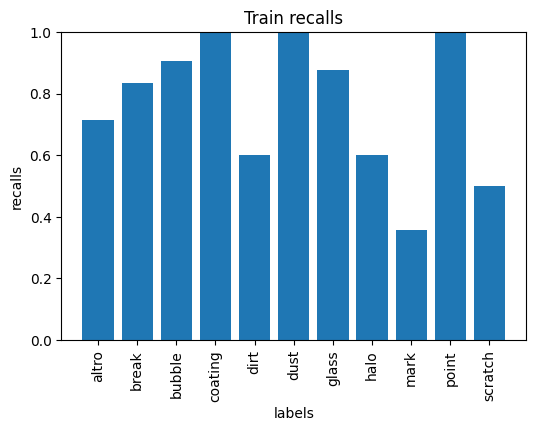

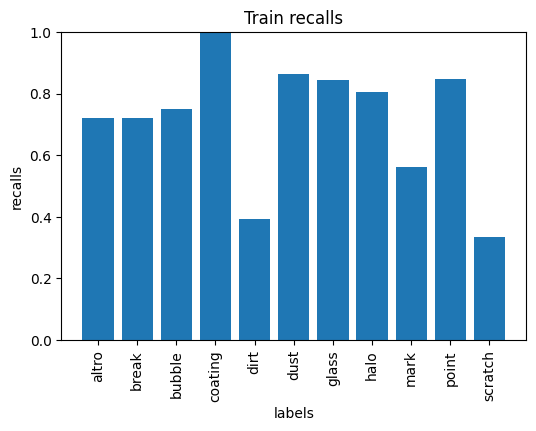

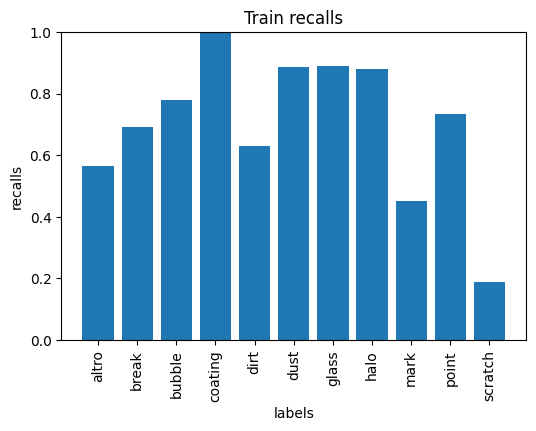

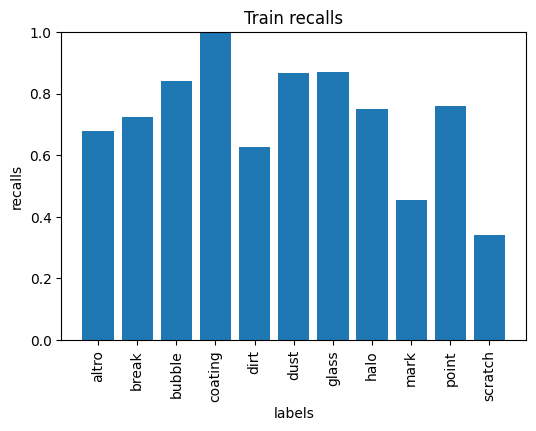

In [66]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

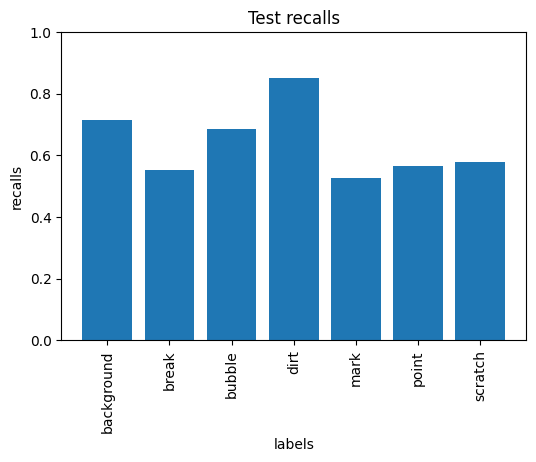

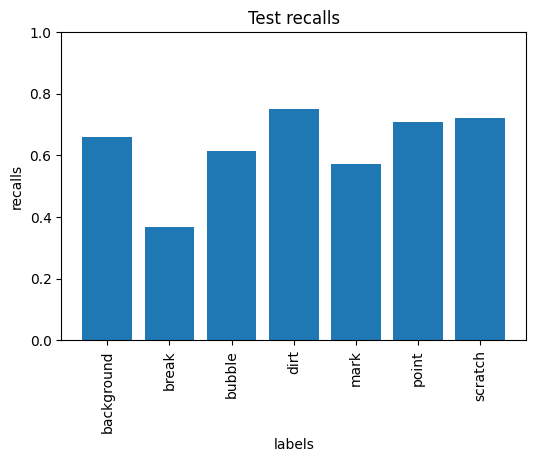

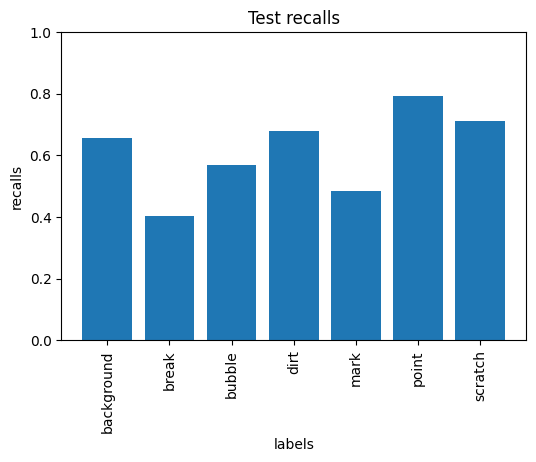

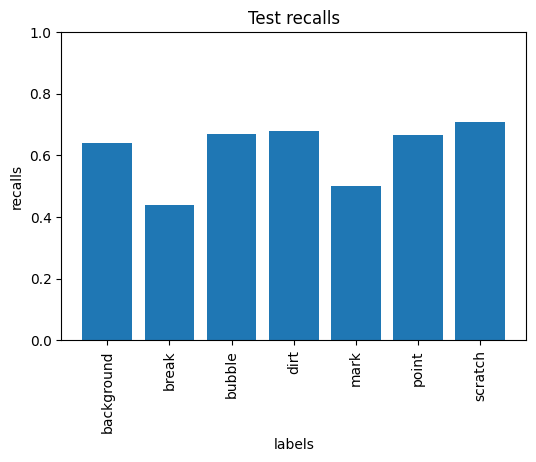

In [67]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

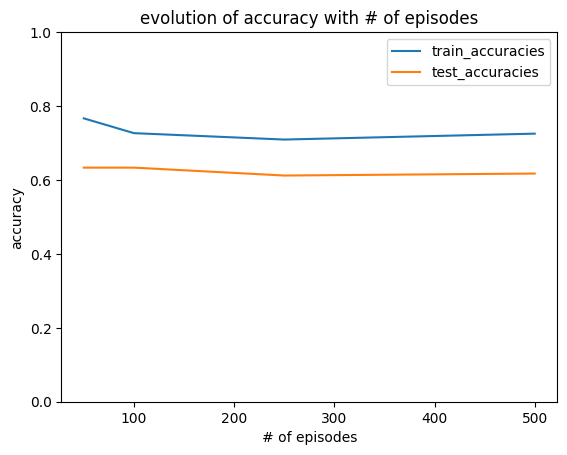

In [68]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus detailed dataset to predict opt_bckg

In [69]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/', '_did_')
train_images_dict = preprocess_images(train_images_dict, 23, fixed_patch_size)

In [70]:
train_classes = set(train_images_classes)
train_classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [71]:
train_target_classes = extend_target_classes(train_images_classes, 4)

In [72]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')
test_images_dict = preprocess_images(test_images_dict, 26, fixed_patch_size)

In [73]:
test_classes = set(test_images_classes)
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [74]:
test_target_classes = extend_target_classes(test_images_classes, 4)

In [75]:
# model = load_protonet_conv(
#     x_dim=(3,60,60),
#     hid_dim=64,
#     z_dim=64,
# )

# optimizer = optim.Adam(model.parameters(), lr = 0.001)

# train_accuracy_dict, train_accuracy  = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 50)

# test_accuracy_dict, test_accuracy  = test(model, test_images_dict, test_target_classes, 3, 1, 1, 50)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

# Training and testing on different number of episodes

In [76]:
increased_episodes = [50, 100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

model = load_protonet_conv(
    x_dim=(3,fixed_patch_size,fixed_patch_size),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 3, 1, 1, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['glass_id' 'mark' 'dust']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['coating' 'bubble_hole' 'scratch_light']
Epoch 2 -- Loss: 0.4795 Acc: 0.0333
K: ['dust' 'point' 'break']
Epoch 3 -- Loss: 0.4795 Acc: 0.0533
K: ['dirt' 'coating' 'dust']
Epoch 4 -- Loss: 0.4795 Acc: 0.0733
K: ['altro' 'point' 'dirt_halo']
Epoch 5 -- Loss: 0.8306 Acc: 0.0800
K: ['dust' 'scratch_multi' 'dirt_halo']
Epoch 6 -- Loss: 1.4497 Acc: 0.0933
K: ['halo' 'bubble_hole' 'dust']
Epoch 7 -- Loss: 2.0432 Acc: 0.1067
K: ['dust' 'scratch_heavy' 'break']
Epoch 8 -- Loss: 11.6869 Acc: 0.1200
K: ['halo' 'dirt_halo' 'scratch_light']
Epoch 9 -- Loss: 11.9673 Acc: 0.1333
K: ['dirt' 'point' 'scratch_heavy']
Epoch 10 -- Loss: 11.9673 Acc: 0.1533
K: ['scratch_light' 'scratch_multi' 'dust']
Epoch 11 -- Loss: 11.9678 Acc: 0.1733
K: ['scratch_multi' 'bubble_hole' 'point']
Epoch 12 -- Loss: 14.6901 Acc: 0.1867
K: ['scratch_heavy' 'scratch_light' 'bubble_hole']
Epoch 13 -- Loss: 16.8864 Acc: 0.2000
K: ['scratch_heavy' 'dust' 'bubble

C:\Users\matte\AppData\Local\Temp\ipykernel_7692\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'scratch' 'dirt']
K: ['background' 'mark' 'bubble']
K: ['background' 'mark' 'scratch']
K: ['mark' 'dirt' 'scratch']
K: ['dirt' 'break' 'mark']
K: ['mark' 'dirt' 'scratch']
K: ['dirt' 'mark' 'break']
K: ['bubble' 'point' 'dirt']
K: ['break' 'dirt' 'scratch']
K: ['mark' 'background' 'break']
K: ['mark' 'break' 'dirt']
K: ['scratch' 'point' 'background']
K: ['mark' 'point' 'bubble']
K: ['scratch' 'break' 'background']
K: ['scratch' 'mark' 'background']
K: ['background' 'bubble' 'point']
K: ['break' 'scratch' 'point']
K: ['break' 'dirt' 'point']
K: ['bubble' 'scratch' 'background']
K: ['break' 'mark' 'scratch']
K: ['mark' 'dirt' 'break']
K: ['background' 'mark' 'dirt']
K: ['break' 'point' 'mark']
K: ['scratch' 'break' 'point']
K: ['bubble' 'point' 'dirt']
K: ['scratch' 'point' 'mark']
K: ['background' 'dirt' 'mark']
K: ['bubble' 'mark' 'point']
K: ['scratch' 'bubble' 'break']
K: ['scratch' 'background' 'dirt']
K: ['bubble' 'dirt' 'background']
K: ['break' 'background' 'bubble']

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['break' 'halo' 'mark']
Epoch 1 -- Loss: 1.7387 Acc: 0.0033
K: ['bubble' 'coating' 'scratch_multi']
Epoch 2 -- Loss: 1.8418 Acc: 0.0100
K: ['altro' 'dirt_halo' 'dust']
Epoch 3 -- Loss: 1.8418 Acc: 0.0200
K: ['glass_id' 'halo' 'bubble']
Epoch 4 -- Loss: 1.8418 Acc: 0.0300
K: ['dirt_halo' 'halo' 'bubble']
Epoch 5 -- Loss: 1.8418 Acc: 0.0400
K: ['dirt' 'bubble_hole' 'break']
Epoch 6 -- Loss: 3.9399 Acc: 0.0467
K: ['bubble' 'coating' 'scratch_light']
Epoch 7 -- Loss: 3.9399 Acc: 0.0567
K: ['coating' 'scratch_multi' 'bubble']
Epoch 8 -- Loss: 3.9399 Acc: 0.0667
K: ['dust' 'scratch_multi' 'bubble_hole']
Epoch 9 -- Loss: 3.9399 Acc: 0.0767
K: ['scratch_light' 'bubble' 'point']
Epoch 10 -- Loss: 3.9399 Acc: 0.0867
K: ['scratch_multi' 'coating' 'point']
Epoch 11 -- Loss: 3.9478 Acc: 0.0933
K: ['altro' 'scratch_light' 'glass_id']
Epoch 12 -- Loss: 4.0545 Acc: 0.0967
K: ['glass_id' 'altro' 'mark']
Epoch 13 -- Loss: 4.2558 Acc: 0.1033
K: ['bubble_hole' 'dirt' 'scratch_multi']
Epoch 14 -- Loss: 

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['scratch' 'mark' 'break']
K: ['bubble' 'scratch' 'background']
K: ['dirt' 'bubble' 'mark']
K: ['dirt' 'point' 'scratch']
K: ['point' 'background' 'mark']
K: ['point' 'dirt' 'break']
K: ['background' 'point' 'break']
K: ['scratch' 'point' 'break']
K: ['bubble' 'break' 'scratch']
K: ['mark' 'break' 'dirt']
K: ['dirt' 'mark' 'point']
K: ['dirt' 'mark' 'break']
K: ['break' 'dirt' 'scratch']
K: ['break' 'scratch' 'bubble']
K: ['point' 'bubble' 'break']
K: ['mark' 'scratch' 'dirt']
K: ['dirt' 'background' 'scratch']
K: ['background' 'point' 'dirt']
K: ['point' 'mark' 'background']
K: ['dirt' 'break' 'mark']
K: ['dirt' 'mark' 'break']
K: ['mark' 'point' 'background']
K: ['break' 'bubble' 'scratch']
K: ['mark' 'background' 'dirt']
K: ['background' 'bubble' 'scratch']
K: ['break' 'bubble' 'dirt']
K: ['dirt' 'background' 'scratch']
K: ['break' 'dirt' 'mark']
K: ['scratch' 'point' 'mark']
K: ['bubble' 'point' 'break']
K: ['bubble' 'point' 'background']
K: ['background' 'bubble' 'break']
K: ['

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt_halo' 'mark' 'bubble']
Epoch 1 -- Loss: 0.2764 Acc: 0.0027
K: ['dirt_halo' 'scratch_heavy' 'halo']
Epoch 2 -- Loss: 0.3302 Acc: 0.0053
K: ['bubble' 'altro' 'dust']
Epoch 3 -- Loss: 0.3926 Acc: 0.0080
K: ['glass_id' 'break' 'dirt']
Epoch 4 -- Loss: 0.5634 Acc: 0.0107
K: ['bubble' 'dirt_halo' 'break']
Epoch 5 -- Loss: 0.5634 Acc: 0.0147
K: ['bubble' 'halo' 'dust']
Epoch 6 -- Loss: 0.8732 Acc: 0.0173
K: ['scratch_light' 'break' 'dust']
Epoch 7 -- Loss: 0.8738 Acc: 0.0213
K: ['halo' 'dirt' 'mark']
Epoch 8 -- Loss: 1.2503 Acc: 0.0213
K: ['scratch_multi' 'scratch_light' 'bubble_hole']
Epoch 9 -- Loss: 1.2503 Acc: 0.0253
K: ['scratch_multi' 'scratch_light' 'bubble']
Epoch 10 -- Loss: 1.2503 Acc: 0.0293
K: ['bubble' 'bubble_hole' 'scratch_heavy']
Epoch 11 -- Loss: 1.3860 Acc: 0.0307
K: ['dust' 'break' 'mark']
Epoch 12 -- Loss: 2.0653 Acc: 0.0333
K: ['halo' 'dirt_halo' 'mark']
Epoch 13 -- Loss: 2.0653 Acc: 0.0373
K: ['scratch_multi' 'bubble' 'break']
Epoch 14 -- Loss: 2.0701 Acc: 0.04

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['point' 'mark' 'background']
K: ['bubble' 'point' 'background']
K: ['background' 'point' 'scratch']
K: ['background' 'dirt' 'mark']
K: ['bubble' 'mark' 'dirt']
K: ['bubble' 'point' 'mark']
K: ['background' 'dirt' 'bubble']
K: ['break' 'point' 'dirt']
K: ['dirt' 'bubble' 'background']
K: ['background' 'break' 'dirt']
K: ['scratch' 'break' 'bubble']
K: ['break' 'dirt' 'mark']
K: ['mark' 'bubble' 'scratch']
K: ['background' 'dirt' 'scratch']
K: ['point' 'break' 'background']
K: ['break' 'mark' 'scratch']
K: ['dirt' 'mark' 'point']
K: ['point' 'dirt' 'scratch']
K: ['background' 'break' 'point']
K: ['background' 'point' 'break']
K: ['point' 'scratch' 'background']
K: ['background' 'break' 'dirt']
K: ['background' 'break' 'point']
K: ['bubble' 'break' 'mark']
K: ['break' 'dirt' 'bubble']
K: ['dirt' 'background' 'break']
K: ['break' 'dirt' 'mark']
K: ['scratch' 'background' 'point']
K: ['background' 'dirt' 'scratch']
K: ['bubble' 'mark' 'scratch']
K: ['break' 'dirt' 'background']
K: ['dir

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['glass_id' 'dirt' 'scratch_heavy']
Epoch 1 -- Loss: 0.1138 Acc: 0.0013
K: ['scratch_light' 'bubble' 'coating']
Epoch 2 -- Loss: 0.1138 Acc: 0.0033
K: ['scratch_multi' 'bubble_hole' 'scratch_heavy']
Epoch 3 -- Loss: 0.1323 Acc: 0.0047
K: ['break' 'scratch_light' 'scratch_heavy']
Epoch 4 -- Loss: 0.6795 Acc: 0.0060
K: ['halo' 'mark' 'glass_id']
Epoch 5 -- Loss: 0.7173 Acc: 0.0073
K: ['dirt_halo' 'dirt' 'glass_id']
Epoch 6 -- Loss: 0.7988 Acc: 0.0087
K: ['dirt' 'dust' 'altro']
Epoch 7 -- Loss: 1.0266 Acc: 0.0093
K: ['dirt_halo' 'bubble' 'coating']
Epoch 8 -- Loss: 1.0376 Acc: 0.0107
K: ['scratch_multi' 'scratch_heavy' 'scratch_light']
Epoch 9 -- Loss: 1.3698 Acc: 0.0113
K: ['dust' 'dirt_halo' 'halo']
Epoch 10 -- Loss: 1.5085 Acc: 0.0127
K: ['mark' 'break' 'bubble']
Epoch 11 -- Loss: 1.6563 Acc: 0.0140
K: ['mark' 'bubble_hole' 'break']
Epoch 12 -- Loss: 1.9278 Acc: 0.0153
K: ['dust' 'bubble' 'glass_id']
Epoch 13 -- Loss: 1.9278 Acc: 0.0173
K: ['scratch_multi' 'scratch_heavy' 'halo']
Ep

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['scratch' 'dirt' 'background']
K: ['dirt' 'scratch' 'background']
K: ['mark' 'background' 'break']
K: ['point' 'dirt' 'break']
K: ['bubble' 'scratch' 'break']
K: ['scratch' 'bubble' 'background']
K: ['mark' 'background' 'bubble']
K: ['break' 'bubble' 'point']
K: ['background' 'scratch' 'break']
K: ['point' 'scratch' 'mark']
K: ['point' 'scratch' 'background']
K: ['scratch' 'bubble' 'dirt']
K: ['break' 'mark' 'bubble']
K: ['point' 'scratch' 'break']
K: ['point' 'mark' 'scratch']
K: ['background' 'scratch' 'point']
K: ['scratch' 'background' 'point']
K: ['point' 'dirt' 'break']
K: ['bubble' 'point' 'mark']
K: ['scratch' 'dirt' 'break']
K: ['point' 'break' 'bubble']
K: ['mark' 'bubble' 'scratch']
K: ['break' 'dirt' 'scratch']
K: ['dirt' 'bubble' 'scratch']
K: ['point' 'bubble' 'mark']
K: ['background' 'point' 'mark']
K: ['break' 'background' 'scratch']
K: ['break' 'background' 'scratch']
K: ['dirt' 'scratch' 'mark']
K: ['background' 'break' 'dirt']
K: ['point' 'dirt' 'background']
K: 

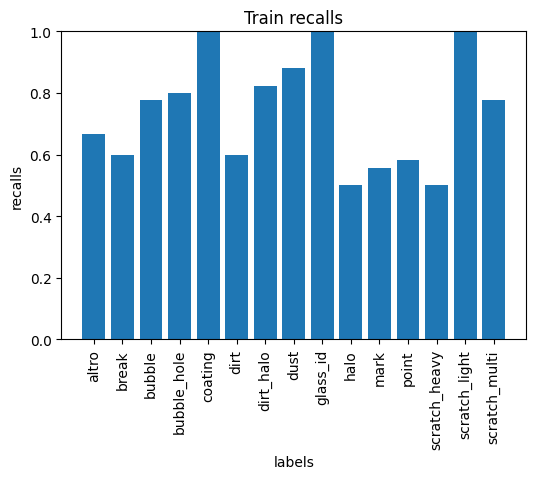

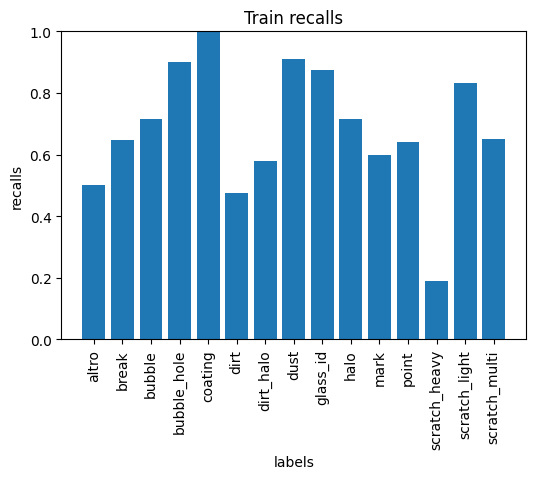

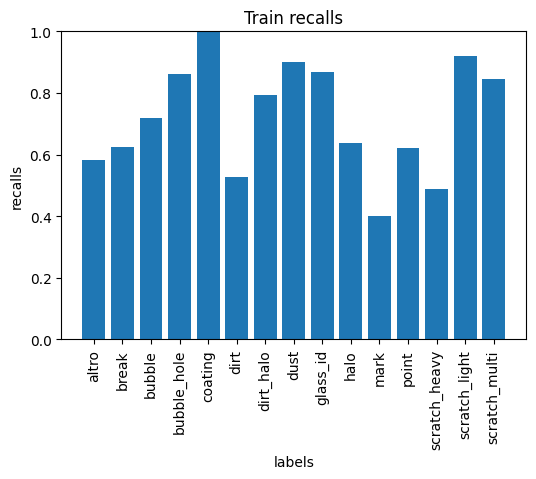

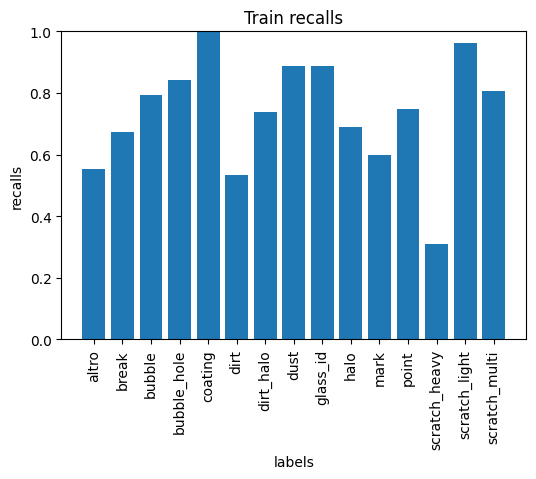

In [77]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

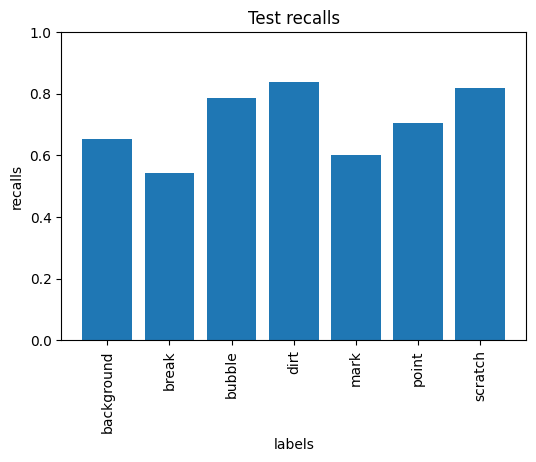

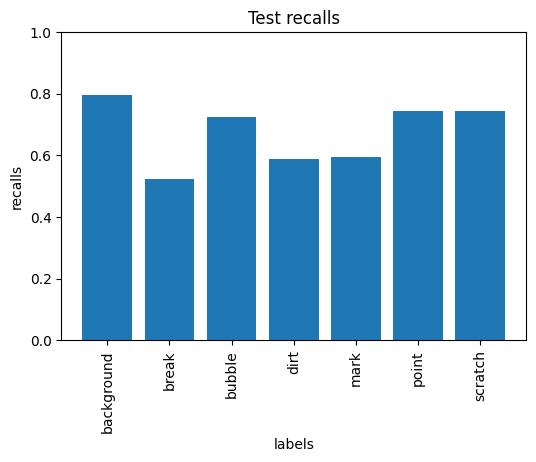

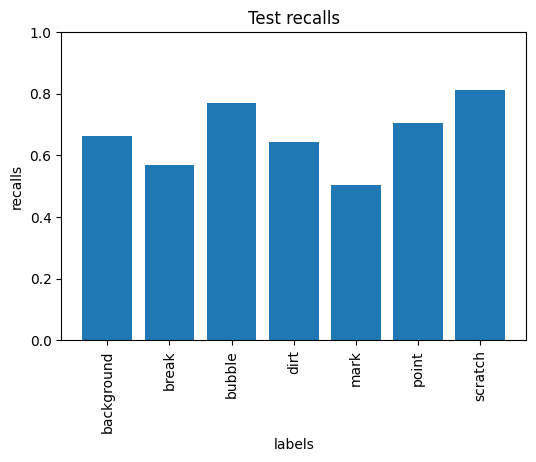

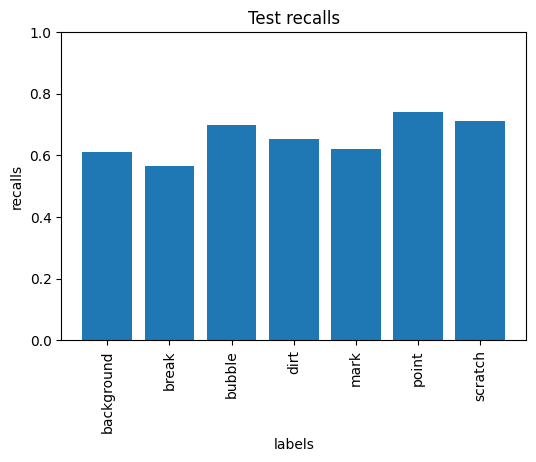

In [78]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

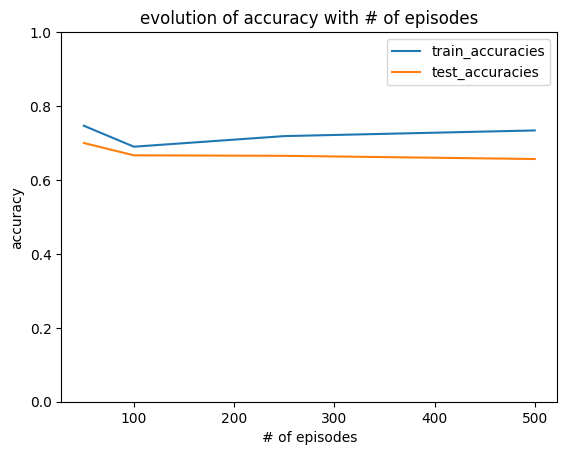

In [79]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)